<a href="https://colab.research.google.com/github/danieldalton13/optimisation_top_Y1/blob/main/02_10_2024_matrix_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Optimisation of Cells - 02/10/2024 updated

## Singular cell - Truss Matrix Solver

* 18 equilibrium equations - 9 nodes with 2 equilibrium equations at each (x and y)
* 18 unknowns - 16 member force unknowns and 2 vertical support reactions
  * The horizontal reaction of support the pin joint is determined seperately through a global equilibrium equation


### System of Equations

The general matrix equation:

$ [A] \{F\} = \{B\} $

can be written element-wise as:


\begin{bmatrix}
A_{11} & A_{12} & A_{13} & \dots & A_{1n} \\
A_{21} & A_{22} & A_{23} & \dots & A_{2n} \\
A_{31} & A_{32} & A_{33} & \dots & A_{3n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
A_{n1} & A_{n2} & A_{n3} & \dots & A_{nn}
\end{bmatrix}
\begin{bmatrix}
F_1 \\
F_2 \\
F_3 \\
\vdots \\
F_n
\end{bmatrix}
=
\begin{bmatrix}
B_1 \\
B_2 \\
B_3 \\
\vdots \\
B_n
\end{bmatrix}

Where:

- $A_{ij}$ are the elements of the stiffness matrix $A$, which represent the contribution of force $F_j$ on the equilibrium at node $i$. Each element is derived from the direction cosines and material properties of the truss members connected to the corresponding nodes.
- $F_j$ are the unknown forces in the truss members and reactions at supports.
- $B_i$ are the external loads applied at each node, such as the downward forces at specific nodes in your truss system.

The matrix $A$ is **square** and typically non-singular, meaning that there is a **unique solution** for $F$ (the member forces and reactions).

The system can be solved directly using:

`F = np.linalg.solve(A, B)`


Member Forces (in kN):
Member 1: -0.62 kN (Compression)
Member 2: -0.62 kN (Compression)
Member 3: -0.00 kN (Compression)
Member 4: -0.00 kN (Compression)
Member 5: -5.62 kN (Compression)
Member 6: -5.62 kN (Compression)
Member 7: 9.38 kN (Tension)
Member 8: 10.00 kN (Tension)
Member 9: 9.37 kN (Tension)
Member 10: 9.38 kN (Tension)
Member 11: -0.00 kN (Compression)
Member 12: 9.37 kN (Tension)
Member 13: 0.88 kN (Tension)
Member 14: 0.88 kN (Tension)
Member 15: 7.95 kN (Tension)
Member 16: 7.95 kN (Tension)

Support Reactions (in kN):
R7y: -15.00 kN
R9y: -15.00 kN

Equilibrium is satisfied.


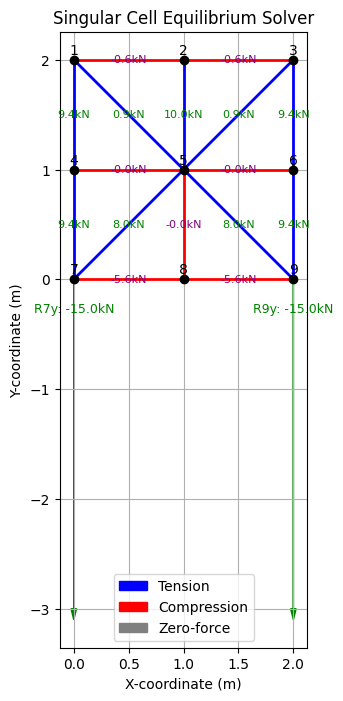

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the nodes and their coordinates (in meters)
nodes = {
    1: (0, 2),
    2: (1, 2),
    3: (2, 2),
    4: (0, 1),
    5: (1, 1),
    6: (2, 1),
    7: (0, 0),
    8: (1, 0),
    9: (2, 0)
}

# Define the members as tuples of connected nodes
members = {
    1: (1, 2),
    2: (2, 3),
    3: (4, 5),
    4: (5, 6),
    5: (7, 8),
    6: (8, 9),
    7: (1, 4),
    8: (2, 5),
    9: (3, 6),
    10: (4, 7),
    11: (5, 8),
    12: (6, 9),
    13: (1, 5),
    14: (3, 5),
    15: (5, 7),
    16: (5, 9)
}

num_members = len(members)       # 16 members
num_nodes = len(nodes)           # 9 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 18 equations

# Define the unknown support reactions
# Assuming support reactions at Node 7 and Node 9 (only Ry are unknown)
# If Rx are also unknown, adjust accordingly
support_reactions = {
    'R7y': None,   # Reaction at Node 7 in y-direction
    'R9y': None    # Reaction at Node 9 in y-direction
}

num_reactions = len(support_reactions)  # 2 reactions
total_unknowns = num_members + num_reactions  # 16 + 2 = 18 unknowns

# Initialize the coefficient matrix A and load vector B
A = np.zeros((total_equations, total_unknowns))  # 18x18 matrix
B = np.zeros(total_equations)                   # 18-element vector

# External Loads
external_loads = {
    1: (0, -10),
    2: (0, -10),
    3: (0, -10),
    # Nodes 4,5,6 have no external loads
    # Nodes 7 and 9 have support reactions now as unknowns
    # Hence, do not assign their reactions in B
}

# Function to compute direction cosines for a member
def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = (x2 - x1) / length
    sin_theta = (y2 - y1) / length
    return cos_theta, sin_theta

# Populate the coefficient matrix A and load vector B
for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] = load[0]
    B[eq_y] = load[1]

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        if node == start or node == end:
            # Determine the direction: outward (+) or inward (-)
            if node == start:
                # Member is going from start to end
                cos_theta, sin_theta = direction_cosines(start, end)
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta
            else:
                # Member is going from end to start
                cos_theta, sin_theta = direction_cosines(end, start)
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta

    # Assign support reactions to the equations if the node has a support
    if node == 7:
        # Reaction R7y affects Sum Fy at Node 7
        A[eq_x, num_members + 0] += 0   # R7x (if exists, here assumed 0)
        A[eq_y, num_members + 0] += 1   # R7y
    if node == 9:
        # Reaction R9y affects Sum Fy at Node 9
        A[eq_x, num_members + 1] += 0   # R9x (if exists, here assumed 0)
        A[eq_y, num_members + 1] += 1   # R9y

# At this point, A * F = B
# Where F is the vector of member forces followed by reaction forces

# Solve the system using an exact solver since it's a square, determinate system
try:
    F = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible
    F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# Extract member forces and reaction forces
member_forces = F[:num_members]
reaction_forces = F[num_members:]

# Display the results
print("Member Forces (in kN):")
for m in members:
    force = member_forces[m - 1]
    if force > 0:
        status = "Tension"
    elif force < 0:
        status = "Compression"
    else:
        status = "Zero-force"
    print(f"Member {m}: {force:.2f} kN ({status})")

print("\nSupport Reactions (in kN):")
for i, reaction in enumerate(support_reactions):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.2f} kN")

# Optional: Check equilibrium (Sum Fx and Sum Fy)
if equilibrium_satisfied:
    print("\nEquilibrium is satisfied.")
else:
    B_calculated = np.dot(A, F)
    difference = B_calculated - B
    tolerance = 1e-6
    if np.all(np.abs(difference) < tolerance):
        print("\nEquilibrium is satisfied.")
    else:
        print("\nEquilibrium is NOT satisfied. Check the calculations.")

# ------------- Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if force > 0:
            color = tension_color
            linewidth = 2
        elif force < 0:
            color = compression_color
            linewidth = 2
        else:
            color = zero_color
            linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='green' if force > 0 else 'purple',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=10, ha='center')

    # Annotate support reactions
    # Assuming reactions are only vertical (Ry)
    # Node 7
    x7, y7 = nodes[7]
    plt.arrow(x7, y7, 0, reaction_forces[0]/5, head_width=0.05, head_length=0.1, fc='green', ec='green')
    plt.text(x7, y7 - 0.3, f"R7y: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='center')

    # Node 9
    x9, y9 = nodes[9]
    plt.arrow(x9, y9, 0, reaction_forces[1]/5, head_width=0.05, head_length=0.1, fc='green', ec='green')
    plt.text(x9, y9 - 0.3, f"R9y: {reaction_forces[1]:.1f}kN", color='green', fontsize=9, ha='center')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch])

    plt.grid(True)
    plt.show()

# Call the plotting function
plot_truss(nodes, members, member_forces, reaction_forces, title="Singular Cell Equilibrium Solver")


## Singular cell - Truss Matrix Solver with Fixed Force Member and Volume Calculation

* 18 equilibrium equations (2 for each node in the x and y direction)
* 18 unknows - 15 bar member forces (1 fixed force member) and 3 support reactions (one pin joint and one roller - so Rx1, Ry1, Ry2)
* Total volume of the structure calculated

Member Forces (in kN):
Member 1: -0.35 kN (Compression)
Member 2: -0.35 kN (Compression)
Member 3: 0.00 kN (Zero-force)
Member 4: 0.00 kN (Zero-force)
Member 5: -5.35 kN (Compression)
Member 6: -5.35 kN (Compression)
Member 7: 9.65 kN (Tension)
Member 8: 10.00 kN (Tension)
Member 9: 9.65 kN (Tension)
Member 10: 9.65 kN (Tension)
Member 11: 0.00 kN (Zero-force)
Member 12: 9.65 kN (Tension)
Member 14: 0.50 kN (Tension)
Member 15: 7.57 kN (Tension)
Member 16: 7.57 kN (Tension)

Fixed Member Forces (in kN):
Member 13: 0.50 kN (Tension)

Support Reactions (in kN):
R7x: 0.00 kN
R7y: -15.00 kN
R9y: -15.00 kN

Equilibrium is satisfied.

Member Volumes (in m³):
Member 1: 0.35 m³
Member 2: 0.35 m³
Member 3: 0.00 m³
Member 4: 0.00 m³
Member 5: 5.35 m³
Member 6: 5.35 m³
Member 7: 9.65 m³
Member 8: 10.00 m³
Member 9: 9.65 m³
Member 10: 9.65 m³
Member 11: 0.00 m³
Member 12: 9.65 m³
Member 13: 0.71 m³
Member 14: 0.71 m³
Member 15: 10.71 m³
Member 16: 10.71 m³

Total Volume of the Structure: 82.83 m³


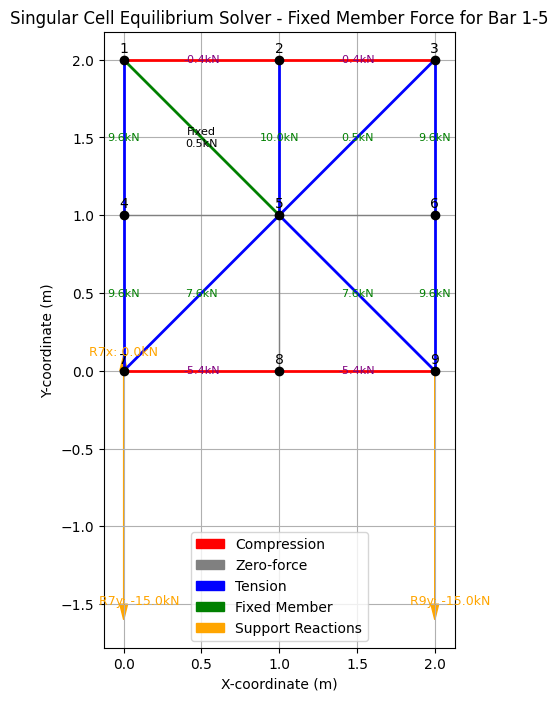

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---------------------- Node and Member Definitions ----------------------

# Define the nodes and their coordinates (in meters)
# Node numbering:
# 1 --- 2 --- 3
# |     |     |
# 4 --- 5 --- 6
# |     |     |
# 7 --- 8 --- 9

nodes = {
    1: (0, 2),
    2: (1, 2),
    3: (2, 2),
    4: (0, 1),
    5: (1, 1),
    6: (2, 1),
    7: (0, 0),
    8: (1, 0),
    9: (2, 0)
}

# Define the members as tuples of connected nodes
# Members are numbered from 1 to 16
# Horizontal Members: M1-M6
# Vertical Members: M7-M12
# Diagonal Members: M13-M16

members = {
    1: (1, 2),
    2: (2, 3),
    3: (4, 5),
    4: (5, 6),
    5: (7, 8),
    6: (8, 9),
    7: (1, 4),
    8: (2, 5),
    9: (3, 6),
    10: (4, 7),
    11: (5, 8),
    12: (6, 9),
    13: (1, 5),  # Fixed member with 0.5 kN
    14: (3, 5),
    15: (5, 7),
    16: (5, 9)
}

# ---------------------- Equilibrium and Force Calculations ----------------------

num_members = len(members)       # 16 members
num_nodes = len(nodes)           # 9 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 18 equations

# ------------------ Define Fixed Members with Fixed Forces ------------------
# Define the members to fix along with their fixed force values (in kN)
fixed_members = {
    13: 0.5  # Member 13 is fixed with a force of 0.5 kN
}
# ---------------------------------------------------------------------------------------

# Identify free (unknown) members by excluding fixed members
free_members = [m for m in members if m not in fixed_members]
num_free_members = len(free_members)  # 15 members

# Define support reactions
# Ry at Nodes 7 and 9 are unknowns
# Rx at Node 7 is also an unknown (newly introduced)
support_reactions = {
    'R7x': None,   # Horizontal reaction at Node 7 (unknown)
    'R7y': None,   # Vertical reaction at Node 7 (unknown)
    'R9y': None    # Vertical reaction at Node 9 (unknown)
}

num_reactions = len(support_reactions)  # 3 reactions
total_unknowns = num_free_members + num_reactions  # 15 + 3 = 18 unknowns

# Initialize the coefficient matrix A and load vector B
A = np.zeros((total_equations, total_unknowns))
B = np.zeros(total_equations)

# External Loads
# Nodes 1, 2, 3 have downward loads of 10 kN each
# Downward loads are negative in the y-direction
external_loads = {
    1: (0, -10),
    2: (0, -10),
    3: (0, -10),
    # Nodes 4,5,6 have no external loads
    # Nodes 7 and 9 have support reactions now as unknowns
}

# Function to compute direction cosines for a member
def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = (x2 - x1) / length
    sin_theta = (y2 - y1) / length
    return cos_theta, sin_theta

# Populate the coefficient matrix A and load vector B
for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] = load[0]
    B[eq_y] = load[1]

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        if node == start or node == end:
            # Check if the member is fixed or free
            if m in fixed_members:
                # Fixed members have known forces; adjust B accordingly
                fixed_force = fixed_members[m]
                # Determine the direction: outward (+) or inward (-)
                if node == start:
                    # Member is going from start to end
                    cos_theta, sin_theta = direction_cosines(start, end)
                    # Subtract the fixed force components from B
                    B[eq_x] -= fixed_force * cos_theta
                    B[eq_y] -= fixed_force * sin_theta
                else:
                    # Member is going from end to start
                    cos_theta, sin_theta = direction_cosines(end, start)
                    # Subtract the fixed force components from B
                    B[eq_x] -= fixed_force * cos_theta
                    B[eq_y] -= fixed_force * sin_theta
            else:
                # Free members have unknown forces; add their contributions to A
                cos_theta, sin_theta = direction_cosines(start, end) if node == start else direction_cosines(end, start)
                # Find the column index for this member in A
                member_index = free_members.index(m)
                if node == start:
                    A[eq_x, member_index] += cos_theta
                    A[eq_y, member_index] += sin_theta
                else:
                    A[eq_x, member_index] += cos_theta
                    A[eq_y, member_index] += sin_theta

    # Assign support reactions to the equations if the node has a support
    if node == 7:
        # Reaction R7x affects Sum Fx at Node 7
        # Reaction R7y affects Sum Fy at Node 7
        # Columns for reactions start after free member columns
        A[eq_x, num_free_members + 0] += 1  # R7x
        A[eq_y, num_free_members + 1] += 1  # R7y
    if node == 9:
        # Reaction R9y affects Sum Fy at Node 9
        A[eq_y, num_free_members + 2] += 1  # R9y

# At this point, A * F = B
# Where F is the vector of [Member forces, R7x, R7y, R9y]

# Solve the system using an exact solver since it's a square, determinate system
try:
    F = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible, fallback to least squares
    F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# Extract member forces and reaction forces
member_forces = F[:num_free_members]
reaction_forces = F[num_free_members:]

# Display the results
print("Member Forces (in kN):")
for i, m in enumerate(free_members):
    force = member_forces[i]
    if force > 1e-6:
        status = "Tension"
    elif force < -1e-6:
        status = "Compression"
    else:
        status = "Zero-force"
    print(f"Member {m}: {force:.2f} kN ({status})")

# Include fixed members with their fixed forces
print("\nFixed Member Forces (in kN):")
for m, force in fixed_members.items():
    status = "Tension" if force > 0 else "Compression" if force < 0 else "Zero-force"
    print(f"Member {m}: {force:.2f} kN ({status})")

print("\nSupport Reactions (in kN):")
reaction_names = list(support_reactions.keys())
for i, reaction in enumerate(reaction_names):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.2f} kN")

# Optional: Check equilibrium (Sum Fx and Sum Fy)
B_calculated = np.dot(A, F)
difference = B_calculated - B
tolerance = 1e-4  # Increased tolerance for floating-point operations

if equilibrium_satisfied:
    print("\nEquilibrium is satisfied.")
else:
    if np.all(np.abs(difference) < tolerance):
        print("\nEquilibrium is satisfied within the tolerance.")
    else:
        print("\nEquilibrium is NOT satisfied. Check the calculations.")

# -------------------- Corrected Code for Volume Calculation --------------------

# Define material stress lts (in kN/m²)
lts = 1  # As per the user's instruction

# Initialize a dictionary to store volumes of each member
member_volumes = {}

# Calculate volume for each member
for m in members:
    start, end = members[m]
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # Length in meters

    if m in fixed_members:
        force = fixed_members[m]  # Fixed member force
    else:
        member_index = free_members.index(m)
        force = member_forces[member_index]

    cross_sectional_area = abs(force) / lts  # A = |F| / σ
    volume = cross_sectional_area * length    # V = A * L
    member_volumes[m] = volume

# Display the volumes
print("\nMember Volumes (in m³):")
for m in members:
    volume = member_volumes[m]
    print(f"Member {m}: {volume:.2f} m³")

# Calculate total volume by summing the absolute volumes
total_volume = sum(member_volumes.values())
print(f"\nTotal Volume of the Structure: {total_volume:.2f} m³")

# -------------------------------------------------------------------------

# ------------- Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, fixed_members, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension, compression, zero-force, fixed members, and reactions
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'
    reaction_color = 'orange'

    # To avoid duplicate labels in the legend
    legend_elements = []

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]

        if m in fixed_members:
            force = fixed_members[m]  # Fixed member force
            color = fixed_color
            linewidth = 2
            label = 'Fixed Member'
            if 'Fixed Member' not in [elem.get_label() for elem in legend_elements]:
                legend_elements.append(mpatches.Patch(color=color, label=label))
        else:
            # Find the index of this member in free_members
            member_index = free_members.index(m)
            force = member_forces[member_index]
            if force > 1e-6:
                color = tension_color
                linewidth = 2
                label = 'Tension'
                if 'Tension' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))
            elif force < -1e-6:
                color = compression_color
                linewidth = 2
                label = 'Compression'
                if 'Compression' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))
            else:
                color = zero_color
                linewidth = 1
                label = 'Zero-force'
                if 'Zero-force' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if m in fixed_members:
            plt.text(x_mid, y_mid, f"Fixed\n{force:.1f}kN", color='black', fontsize=8, ha='center', va='center')
        else:
            if abs(force) > 1e-6:
                text_color = 'green' if force > 0 else 'purple'
                plt.text(x_mid, y_mid, f"{force:.1f}kN", color=text_color,
                         fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=10, ha='center')

    # Annotate support reactions
    # Node 7: R7x and R7y
    x7, y7 = nodes[7]
    # Plot Rx at Node7
    plt.arrow(x7, y7, reaction_forces[0]/10, 0, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x7 + reaction_forces[0]/10, y7 + 0.1, f"R7x: {reaction_forces[0]:.1f}kN", color=reaction_color, fontsize=9, ha='center')
    # Plot Ry at Node7
    plt.arrow(x7, y7, 0, reaction_forces[1]/10, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x7 + 0.1, y7 + reaction_forces[1]/10, f"R7y: {reaction_forces[1]:.1f}kN", color=reaction_color, fontsize=9, ha='center')

    # Node 9: R9y
    x9, y9 = nodes[9]
    # Plot Ry at Node9
    plt.arrow(x9, y9, 0, reaction_forces[2]/10, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x9 + 0.1, y9 + reaction_forces[2]/10, f"R9y: {reaction_forces[2]:.1f}kN", color=reaction_color, fontsize=9, ha='center')

    # Create custom legend
    # Add legend elements
    plt.legend(handles=legend_elements + [mpatches.Patch(color=reaction_color, label='Support Reactions')])

    plt.grid(True)
    plt.show()

# Call the plotting function with fixed_members and reaction forces
plot_truss(
    nodes,
    members,
    member_forces,
    fixed_members,
    reaction_forces,
    title="Singular Cell Equilibrium Solver - Fixed Member Force for Bar 1-5"
)


## Single Cell - Fixed Force Value now varied in a GA to Minimise Volume

* Seed is taken from the full structure equilibrium taken - 0.5kN for member 1-5

Starting Genetic Algorithm for Truss Volume Optimization...

Generation 1: Best Volume = 84.59 m³ | Fixed Force M13 = -1.62 kN
Generation 2: Best Volume = 82.12 m³ | Fixed Force M13 = -0.75 kN
Generation 3: Best Volume = 83.36 m³ | Fixed Force M13 = -1.19 kN
Generation 4: Best Volume = 80.25 m³ | Fixed Force M13 = -0.09 kN
Generation 5: Best Volume = 80.25 m³ | Fixed Force M13 = -0.09 kN
Generation 6: Best Volume = 80.25 m³ | Fixed Force M13 = -0.09 kN
Generation 7: Best Volume = 80.01 m³ | Fixed Force M13 = -0.00 kN
Generation 8: Best Volume = 80.01 m³ | Fixed Force M13 = -0.00 kN
Generation 9: Best Volume = 80.01 m³ | Fixed Force M13 = -0.00 kN
Generation 10: Best Volume = 80.00 m³ | Fixed Force M13 = 0.00 kN
Generation 11: Best Volume = 80.00 m³ | Fixed Force M13 = 0.00 kN
Generation 12: Best Volume = 80.00 m³ | Fixed Force M13 = 0.00 kN
Generation 13: Best Volume = 80.00 m³ | Fixed Force M13 = 0.00 kN
Generation 14: Best Volume = 80.00 m³ | Fixed Force M13 = 0.00 kN
Generation 15: 

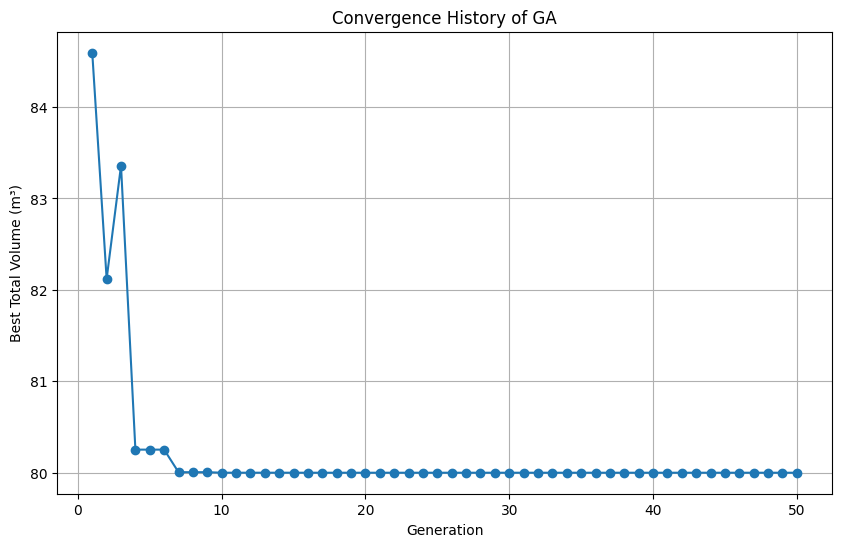

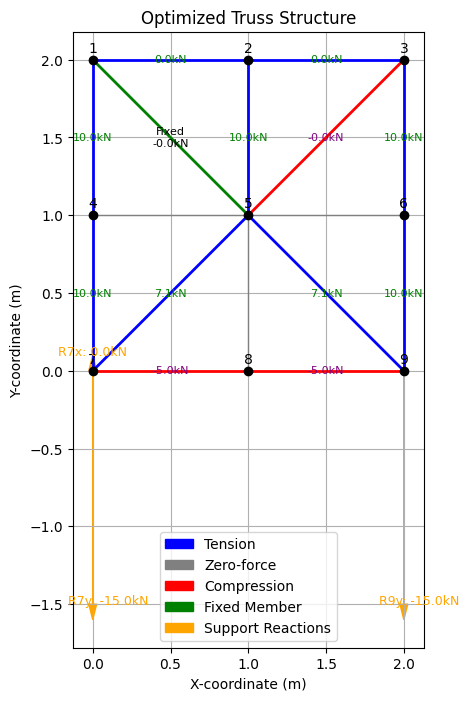

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# ---------------------- Node and Member Definitions ----------------------

# Define the nodes and their coordinates (in meters)
# Node numbering:
# 1 --- 2 --- 3
# |     |     |
# 4 --- 5 --- 6
# |     |     |
# 7 --- 8 --- 9

nodes = {
    1: (0, 2),
    2: (1, 2),
    3: (2, 2),
    4: (0, 1),
    5: (1, 1),
    6: (2, 1),
    7: (0, 0),
    8: (1, 0),
    9: (2, 0)
}

# Define the members as tuples of connected nodes
# Members are numbered from 1 to 16
# Horizontal Members: M1-M6
# Vertical Members: M7-M12
# Diagonal Members: M13-M16

members = {
    1: (1, 2),
    2: (2, 3),
    3: (4, 5),
    4: (5, 6),
    5: (7, 8),
    6: (8, 9),
    7: (1, 4),
    8: (2, 5),
    9: (3, 6),
    10: (4, 7),
    11: (5, 8),
    12: (6, 9),
    13: (1, 5),  # Fixed member with variable force
    14: (3, 5),
    15: (5, 7),
    16: (5, 9)
}

# ---------------------- Truss Analysis Function ----------------------

def truss_analysis(fixed_force_m13):
    """
    Performs truss analysis with a given fixed force for Member 13.

    Parameters:
    - fixed_force_m13 (float): Fixed force value for Member 13 in kN.

    Returns:
    - total_volume (float): Total volume of the truss structure in m³.
    - member_volumes (dict): Volumes of individual members.
    - reaction_forces (dict): Support reaction forces.
    - member_forces (dict): Forces in individual members.
    - success (bool): Indicates if the analysis was successful.
    """
    num_members = len(members)       # 16 members
    num_nodes = len(nodes)           # 9 nodes
    equations_per_node = 2           # Sum Fx and Fy for each node
    total_equations = num_nodes * equations_per_node  # 18 equations

    # ------------------ Define Fixed Members with Fixed Forces ------------------
    # Define the members to fix along with their fixed force values (in kN)
    fixed_members = {
        13: fixed_force_m13  # Member 13 is fixed with a variable force
    }
    # ---------------------------------------------------------------------------------------

    # Identify free (unknown) members by excluding fixed members
    free_members = [m for m in members if m not in fixed_members]
    num_free_members = len(free_members)  # 15 members

    # Define support reactions
    # Ry at Nodes 7 and 9 are unknowns
    # Rx at Node 7 is also an unknown (newly introduced)
    support_reactions = {
        'R7x': None,   # Horizontal reaction at Node 7 (unknown)
        'R7y': None,   # Vertical reaction at Node 7 (unknown)
        'R9y': None    # Vertical reaction at Node 9 (unknown)
    }

    num_reactions = len(support_reactions)  # 3 reactions
    total_unknowns = num_free_members + num_reactions  # 15 + 3 = 18 unknowns

    # Initialize the coefficient matrix A and load vector B
    A = np.zeros((total_equations, total_unknowns))
    B = np.zeros(total_equations)

    # External Loads
    # Nodes 1, 2, 3 have downward loads of 10 kN each
    # Downward loads are negative in the y-direction
    external_loads = {
        1: (0, -10),
        2: (0, -10),
        3: (0, -10),
        # Nodes 4,5,6 have no external loads
        # Nodes 7 and 9 have support reactions now as unknowns
    }

    # Function to compute direction cosines for a member
    def direction_cosines(start, end):
        x1, y1 = nodes[start]
        x2, y2 = nodes[end]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = (x2 - x1) / length
        sin_theta = (y2 - y1) / length
        return cos_theta, sin_theta

    # Populate the coefficient matrix A and load vector B
    for node in nodes:
        # Equation indices
        eq_x = (node - 1) * 2      # Sum Fx
        eq_y = eq_x + 1            # Sum Fy

        # Assign external loads to B
        load = external_loads.get(node, (0, 0))
        B[eq_x] = load[0]
        B[eq_y] = load[1]

        # Iterate through all members to see if they are connected to the current node
        for m in members:
            start, end = members[m]
            if node == start or node == end:
                # Check if the member is fixed or free
                if m in fixed_members:
                    # Fixed members have known forces; adjust B accordingly
                    fixed_force = fixed_members[m]
                    # Determine the direction: outward (+) or inward (-)
                    if node == start:
                        # Member is going from start to end
                        cos_theta, sin_theta = direction_cosines(start, end)
                        # Subtract the fixed force components from B
                        B[eq_x] -= fixed_force * cos_theta
                        B[eq_y] -= fixed_force * sin_theta
                    else:
                        # Member is going from end to start
                        cos_theta, sin_theta = direction_cosines(end, start)
                        # Subtract the fixed force components from B
                        B[eq_x] -= fixed_force * cos_theta
                        B[eq_y] -= fixed_force * sin_theta
                else:
                    # Free members have unknown forces; add their contributions to A
                    cos_theta, sin_theta = direction_cosines(start, end) if node == start else direction_cosines(end, start)
                    # Find the column index for this member in A
                    member_index = free_members.index(m)
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta

        # Assign support reactions to the equations if the node has a support
        if node == 7:
            # Reaction R7x affects Sum Fx at Node 7
            # Reaction R7y affects Sum Fy at Node 7
            # Columns for reactions start after free member columns
            A[eq_x, num_free_members + 0] += 1  # R7x
            A[eq_y, num_free_members + 1] += 1  # R7y
        if node == 9:
            # Reaction R9y affects Sum Fy at Node 9
            A[eq_y, num_free_members + 2] += 1  # R9y

    # At this point, A * F = B
    # Where F is the vector of [Member forces, R7x, R7y, R9y]

    # Solve the system using an exact solver since it's a square, determinate system
    try:
        F = np.linalg.solve(A, B)
        equilibrium_satisfied = True
    except np.linalg.LinAlgError:
        # If A is singular or not invertible, return failure
        return None, None, None, None, False

    # Extract member forces and reaction forces
    member_forces_values = F[:num_free_members]
    reaction_forces_values = F[num_free_members:]

    # Create a dictionary for member forces
    member_forces = {}
    for i, m in enumerate(free_members):
        member_forces[m] = member_forces_values[i]

    # Create a dictionary for support reactions
    reaction_forces = {}
    for i, reaction in enumerate(support_reactions.keys()):
        reaction_forces[reaction] = reaction_forces_values[i]

    # Define material stress lts (in kN/m²)
    lts = 1  # As per the user's instruction

    # Initialize a dictionary to store volumes of each member
    member_volumes = {}

    # Calculate volume for each member
    for m in members:
        start, end = members[m]
        x1, y1 = nodes[start]
        x2, y2 = nodes[end]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # Length in meters

        if m in fixed_members:
            force = fixed_members[m]  # Fixed member force
        else:
            force = member_forces[m]

        cross_sectional_area = abs(force) / lts  # A = |F| / σ
        volume = cross_sectional_area * length    # V = A * L
        member_volumes[m] = volume

    # Calculate total volume by summing the absolute volumes
    total_volume = sum(member_volumes.values())

    # Create a dictionary for member forces including fixed members
    all_member_forces = member_forces.copy()
    for m, force in fixed_members.items():
        all_member_forces[m] = force

    return total_volume, member_volumes, reaction_forces, all_member_forces, True

# ---------------------- Genetic Algorithm Implementation ----------------------

def genetic_algorithm(
    population_size=20,
    generations=50,
    mutation_rate=0.1,
    crossover_rate=0.7,
    fixed_force_seed=0.5,
    fixed_force_range=(0.1, 10.0)
):
    """
    Implements a Genetic Algorithm to optimize the fixed force in Member 13
    for minimizing the total volume of the truss structure.

    Parameters:
    - population_size (int): Number of candidates in the population.
    - generations (int): Number of generations to run the GA.
    - mutation_rate (float): Probability of mutation.
    - crossover_rate (float): Probability of crossover.
    - fixed_force_seed (float): Initial seed value for fixed force.
    - fixed_force_range (tuple): Minimum and maximum allowable fixed force values.

    Returns:
    - best_candidate (float): Optimal fixed force value for Member 13.
    - best_volume (float): Corresponding total volume.
    - history (list): History of best volumes per generation.
    """
    # Initialize population around the seed value within the defined range
    population = [random.uniform(fixed_force_range[0], fixed_force_range[1]) for _ in range(population_size)]
    history = []

    for gen in range(generations):
        # Evaluate fitness: lower volume is better
        fitness = []
        for candidate in population:
            total_volume, _, _, _, success = truss_analysis(candidate)
            if success:
                fitness.append(total_volume)
            else:
                # Assign a high penalty if the system is unsolvable
                fitness.append(1e6)

        # Find the best candidate in the current generation
        min_fitness = min(fitness)
        min_index = fitness.index(min_fitness)
        best_candidate = population[min_index]
        history.append(min_fitness)

        print(f"Generation {gen+1}: Best Volume = {min_fitness:.2f} m³ | Fixed Force M13 = {best_candidate:.2f} kN")

        # Selection: Tournament Selection
        selected = []
        for _ in range(population_size):
            i, j = random.sample(range(population_size), 2)
            if fitness[i] < fitness[j]:
                selected.append(population[i])
            else:
                selected.append(population[j])

        # Crossover: Single-point crossover
        next_generation = []
        for i in range(0, population_size, 2):
            parent1 = selected[i]
            parent2 = selected[i+1] if i+1 < population_size else selected[0]
            if random.random() < crossover_rate:
                # Perform crossover by averaging
                child1 = (parent1 + parent2) / 2
                child2 = (parent1 + parent2) / 2
                next_generation.extend([child1, child2])
            else:
                next_generation.extend([parent1, parent2])

        # Mutation: Add small random value
        for i in range(population_size):
            if random.random() < mutation_rate:
                # Apply mutation within a small range
                mutation_value = random.uniform(-0.5, 0.5)
                mutated = next_generation[i] + mutation_value
                # Ensure mutated value is within the defined range
                mutated = max(fixed_force_range[0], min(mutated, fixed_force_range[1]))
                next_generation[i] = mutated

        population = next_generation

    # After all generations, find the best candidate
    final_fitness = []
    for candidate in population:
        total_volume, _, _, _, success = truss_analysis(candidate)
        if success:
            final_fitness.append(total_volume)
        else:
            final_fitness.append(1e6)

    min_fitness = min(final_fitness)
    min_index = final_fitness.index(min_fitness)
    best_candidate = population[min_index]

    return best_candidate, min_fitness, history

# ---------------------- Visualization Function ----------------------

def plot_truss(nodes, members, member_forces, fixed_members, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension, compression, zero-force, fixed members, and reactions
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'
    reaction_color = 'orange'

    # To avoid duplicate labels in the legend
    legend_elements = []

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]

        if m in fixed_members:
            force = fixed_members[m]  # Fixed member force
            color = fixed_color
            linewidth = 2
            label = 'Fixed Member'
            if 'Fixed Member' not in [elem.get_label() for elem in legend_elements]:
                legend_elements.append(mpatches.Patch(color=color, label=label))
        else:
            # Find the force for this member
            force = member_forces[m]
            if force > 1e-6:
                color = tension_color
                linewidth = 2
                label = 'Tension'
                if 'Tension' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))
            elif force < -1e-6:
                color = compression_color
                linewidth = 2
                label = 'Compression'
                if 'Compression' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))
            else:
                color = zero_color
                linewidth = 1
                label = 'Zero-force'
                if 'Zero-force' not in [elem.get_label() for elem in legend_elements]:
                    legend_elements.append(mpatches.Patch(color=color, label=label))

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if m in fixed_members:
            plt.text(x_mid, y_mid, f"Fixed\n{force:.1f}kN", color='black', fontsize=8, ha='center', va='center')
        else:
            if abs(force) > 1e-6:
                text_color = 'green' if force > 0 else 'purple'
                plt.text(x_mid, y_mid, f"{force:.1f}kN", color=text_color,
                         fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=10, ha='center')

    # Annotate support reactions
    # Node 7: R7x and R7y
    x7, y7 = nodes[7]
    # Plot Rx at Node7
    plt.arrow(x7, y7, reaction_forces['R7x']/10, 0, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x7 + reaction_forces['R7x']/10, y7 + 0.1, f"R7x: {reaction_forces['R7x']:.1f}kN", color=reaction_color, fontsize=9, ha='center')
    # Plot Ry at Node7
    plt.arrow(x7, y7, 0, reaction_forces['R7y']/10, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x7 + 0.1, y7 + reaction_forces['R7y']/10, f"R7y: {reaction_forces['R7y']:.1f}kN", color=reaction_color, fontsize=9, ha='center')

    # Node 9: R9y
    x9, y9 = nodes[9]
    # Plot Ry at Node9
    plt.arrow(x9, y9, 0, reaction_forces['R9y']/10, head_width=0.05, head_length=0.1, fc=reaction_color, ec=reaction_color)
    plt.text(x9 + 0.1, y9 + reaction_forces['R9y']/10, f"R9y: {reaction_forces['R9y']:.1f}kN", color=reaction_color, fontsize=9, ha='center')

    # Create custom legend
    # Add legend elements
    legend_elements.append(mpatches.Patch(color=reaction_color, label='Support Reactions'))
    plt.legend(handles=legend_elements)

    plt.grid(True)
    plt.show()

# ---------------------- Main Execution ----------------------

def main():
    # Genetic Algorithm Parameters
    population_size = 20
    generations = 50
    mutation_rate = 0.1
    crossover_rate = 0.7
    fixed_force_seed = 0.5
    fixed_force_range = (-20, 20.0)  # Define a reasonable range for fixed force

    print("Starting Genetic Algorithm for Truss Volume Optimization...\n")

    # Run Genetic Algorithm
    best_fixed_force, best_volume, history = genetic_algorithm(
        population_size=population_size,
        generations=generations,
        mutation_rate=mutation_rate,
        crossover_rate=crossover_rate,
        fixed_force_seed=fixed_force_seed,
        fixed_force_range=fixed_force_range
    )

    print("\nOptimization Completed.")
    print(f"Optimal Fixed Force for Member 13: {best_fixed_force:.2f} kN")
    print(f"Corresponding Total Volume: {best_volume:.2f} m³")

    # Perform truss analysis with the optimal fixed force
    total_volume, member_volumes, reaction_forces, member_forces, success = truss_analysis(best_fixed_force)

    if success:
        # Display the results
        print("\nMember Forces (in kN):")
        for m in sorted(member_forces.keys()):
            force = member_forces[m]
            status = "Tension" if force > 1e-6 else "Compression" if force < -1e-6 else "Zero-force"
            print(f"Member {m}: {force:.2f} kN ({status})")

        # Include fixed members with their fixed forces
        print("\nFixed Member Forces (in kN):")
        for m, force in {13: best_fixed_force}.items():
            status = "Tension" if force > 0 else "Compression" if force < 0 else "Zero-force"
            print(f"Member {m}: {force:.2f} kN ({status})")

        print("\nSupport Reactions (in kN):")
        for reaction, force in reaction_forces.items():
            print(f"{reaction}: {force:.2f} kN")

        print("\nTotal Volume of the Structure: {:.2f} m³".format(total_volume))

        # Optional: Plot the convergence history
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, generations + 1), history, marker='o')
        plt.title('Convergence History of GA')
        plt.xlabel('Generation')
        plt.ylabel('Best Total Volume (m³)')
        plt.grid(True)
        plt.show()

        # Plot the optimized truss
        plot_truss(
            nodes,
            members,
            member_forces=member_forces,
            fixed_members={13: best_fixed_force},
            reaction_forces=reaction_forces,
            title="Optimized Truss Structure"
        )
    else:
        print("Truss analysis with the optimal fixed force was unsuccessful.")

if __name__ == "__main__":
    main()

## Triple Cell - Truss Equilibrium Finder

* Nodes: 21 nodes.
* Members: 44 members (including vertical, horizontal, and diagonal members).
* Reactions: 3 reactions (R15x and R15y at node 15, and R21y at node 21).
* Total Equations: Since there are 21 nodes, each node has two equilibrium equations (for forces in the x- and y-directions), resulting in 42 equations.
* Unknowns: 44 unknown member forces + 3 unknown reactions = 47 unknowns.
* **Degree of Indeterminacy**: The system has 47 unknowns and 42 equations, resulting in a degree of indeterminacy of 5 (47 - 42 = 5).

 #### **The general matrix equation**:

$ [A] \{F\} = \{B\} $

can be written element-wise as:


\begin{bmatrix}
A_{11} & A_{12} & A_{13} & \dots & A_{1n} \\
A_{21} & A_{22} & A_{23} & \dots & A_{2n} \\
A_{31} & A_{32} & A_{33} & \dots & A_{3n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
A_{n1} & A_{n2} & A_{n3} & \dots & A_{nn}
\end{bmatrix}
\begin{bmatrix}
F_1 \\
F_2 \\
F_3 \\
\vdots \\
F_n
\end{bmatrix}
=
\begin{bmatrix}
B_1 \\
B_2 \\
B_3 \\
\vdots \\
B_n
\end{bmatrix}


The matrix A is **underdetermined** because there are more unknowns (51) than equations (42).

In this case, `np.linalg.solve` cannot be used because A is **not square**. Instead, the code uses the **least squares solution** (`np.linalg.lstsq`), which provides an approximate solution by minimizing the residuals:

`F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)`

#### **The Least Squares Method**

In the least squares method, we solve:

$
\min \|\{B\} - [A] \{F\}\|^2
$

This means we find the vector $F$ (the unknown forces) that minimizes the squared difference between the actual external loads $B$ and the loads implied by the solution of the matrix equation $[A]\times F$.

In matrix terms, the least squares solution to $[A] \times F = B$ is given by:

$
F = \left([A]^T [A]\right)^{-1} [A]^T B
$

Where:

- $[A]^T$ is the transpose of the matrix $[A]$.
- $\left([A]^T [A]\right)^{-1}$ is the inverse of the product of the transpose of $[A]$ and $[A]$.

This method finds the solution vector $F$ that best fits the system in the least-squares sense, even though the system is underdetermined.


Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12            13            1.509434      Tension        
Member 12    13            14            0.000000     

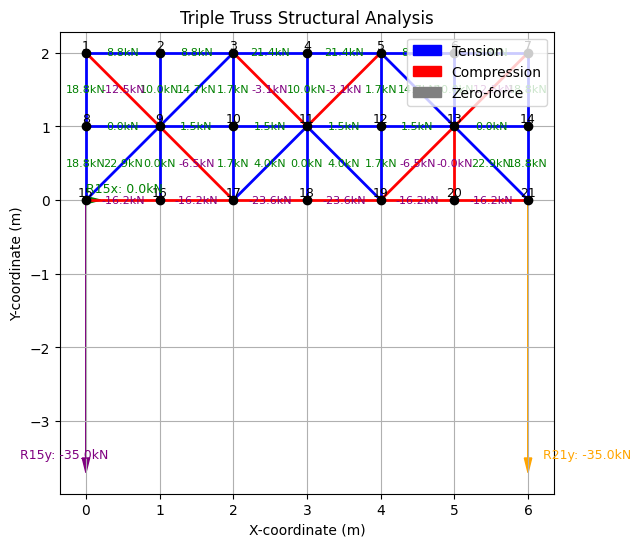

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ------------- 1. Define the Nodes -------------

# Initialize nodes dictionary
nodes = {}
node_id = 1

# Create 7 columns (x=0 to 6) and 3 rows (y=2 to 0)
for y in range(2, -1, -1):  # y=2 (top) to y=0 (bottom)
    for x in range(7):       # x=0 to x=6
        nodes[node_id] = (x, y)
        node_id += 1

# ------------- 2. Define the Members -------------

# Reset members dictionary
members = {}
member_id = 1

# Function to add a member between two nodes with validation
def add_member(start, end):
    global member_id
    # Check if both start and end nodes exist
    if start in nodes and end in nodes:
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any((start == existing_start and end == existing_end) or
                   (start == existing_end and end == existing_start)
                   for existing_start, existing_end in members.values()):
            members[member_id] = (start, end)
            member_id += 1
    else:
        print(f"Skipping member ({start}, {end}) - Invalid node number.")

# ------------- Add Horizontal Members -------------
# Top Row: Nodes 1-7
for i in range(1, 7):
    add_member(i, i+1)

# Middle Row: Nodes 8-14
for i in range(8, 14):
    add_member(i, i+1)

# Bottom Row: Nodes 15-21
for i in range(15, 21):
    add_member(i, i+1)

# ------------- Add Vertical Members -------------
# Columns 1 to 7: Connect top to middle to bottom
for col in range(1, 8):
    top_node = col
    middle_node = col + 7
    bottom_node = col + 14
    add_member(top_node, middle_node)
    add_member(middle_node, bottom_node)

# ------------- Add Diagonal Members at Middle Nodes 9, 11, 13 -------------

# Define middle nodes where diagonals will be added
middle_nodes = [9, 11, 13]

# Directions: up-left, up-right, down-left, down-right
directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

for node in middle_nodes:
    x, y = nodes[node]
    for dx, dy in directions:
        diag_x = x + dx
        diag_y = y + dy
        # Find the node that matches (diag_x, diag_y)
        diag_node = None
        for nid, coord in nodes.items():
            if coord == (diag_x, diag_y):
                diag_node = nid
                break
        if diag_node:
            add_member(node, diag_node)

# ------------- 3. Define Support Reactions -------------

# Supports are at Node 15 (pin: R15x, R15y) and Node 21 (roller: R21y)
support_reactions = {
    'R15x': None,   # Reaction at Node 15 in x-direction
    'R15y': None,   # Reaction at Node 15 in y-direction
    'R21y': None    # Reaction at Node 21 in y-direction
}

num_reactions = len(support_reactions)  # 3 reactions

# ------------- 4. Initialize the System of Equilibrium Equations -------------

num_members = len(members)       # Number of members
num_nodes = len(nodes)           # 21 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 42 equations

total_unknowns = num_members + num_reactions  # Members + reactions

# Initialize the coefficient matrix A and load vector B
A = np.zeros((total_equations, total_unknowns))  # 42x(total_unknowns)
B = np.zeros(total_equations)                   # 42-element vector

# ------------- 5. Define External Loads -------------

# Evenly distributed downward loads on top nodes (Nodes 1 to 7)
external_loads = {}
load_magnitude = 10  # kN per node

for node in range(1, 8):  # Nodes 1 to 7
    external_loads[node] = (0, -load_magnitude)  # (Fx, Fy)

# ------------- 6. Define Direction Cosines -------------

def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    delta_x = x2 - x1
    delta_y = y2 - y1
    length = np.sqrt(delta_x**2 + delta_y**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = delta_x / length
    sin_theta = delta_y / length
    return cos_theta, sin_theta

# ------------- 7. Populate the Coefficient Matrix A and Load Vector B -------------

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] += load[0]  # External load in x-direction
    B[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        if node == start or node == end:
            # Determine the direction: outward (+) or inward (-)
            if node == start:
                # Member is going from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta
            else:
                # Member is going from end to start
                try:
                    cos_theta, sin_theta = direction_cosines(end, start)
                except ValueError as ve:
                    print(ve)
                    continue
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A[eq_x, num_members + 0] += 1   # R15x
        A[eq_y, num_members + 1] += 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A[eq_y, num_members + 2] += 1   # R21y

# ------------- 8. Solve the System -------------

# Solve the system A * F = B
try:
    F = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible, use least squares
    F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# Extract member forces and reaction forces
member_forces = F[:num_members]
reaction_forces = F[num_members:]

# ------------- 9. Display the Results -------------

# Display member forces with start and end nodes
print("Member Forces (in kN):")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
print("-" * 70)
for m in members:
    start, end = members[m]
    force = member_forces[m - 1]
    if force > 0:
        status = "Tension"
    elif force < 0:
        status = "Compression"
    else:
        status = "Zero-force"
    print(f"Member {m:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

# Display support reactions
print("\nSupport Reactions (in kN):")
for i, reaction in enumerate(support_reactions):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.6f} kN")

# Check equilibrium
if equilibrium_satisfied:
    print("\nEquilibrium is satisfied.")
else:
    B_calculated = np.dot(A, F)
    difference = B_calculated - B
    tolerance = 1e-7
    if np.all(np.abs(difference) < tolerance):
        print("\nEquilibrium is satisfied.")
    else:
        print("\nEquilibrium is NOT satisfied. Check the calculations.")

# ------------- 10. Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if force > 0:
            color = tension_color
            linewidth = 2
        elif force < 0:
            color = compression_color
            linewidth = 2
        else:
            color = zero_color
            linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='green' if force > 0 else 'purple',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    plt.arrow(x15, y15, reaction_forces[0]/10, 0, head_width=0.1, head_length=0.2, fc='green', ec='green')
    plt.text(x15 + reaction_forces[0]/10, y15 + 0.1, f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    plt.arrow(x15, y15, 0, reaction_forces[1]/10, head_width=0.1, head_length=0.2, fc='purple', ec='purple')
    plt.text(x15 - 0.3, y15 + reaction_forces[1]/10, f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    plt.arrow(x21, y21, 0, reaction_forces[2]/10, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
    plt.text(x21 + 0.2, y21 + reaction_forces[2]/10, f"R21y: {reaction_forces[2]:.1f}kN", color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Call the plotting function with the updated structure
plot_truss(nodes, members, member_forces, reaction_forces, title="Triple Truss Structural Analysis")

## Triple cell - fixed force structural analysis

* Note here: Equilibrium was only satisfied when fixed member force is defined at 6 decimal places (did not work at 2dp).

Fixed Member Forces (in kN):
Member 33 (Node 9 to Node 1): -12.47 kN
Member 35 (Node 9 to Node 15): 22.88 kN
Member 37 (Node 11 to Node 3): -3.07 kN
Member 39 (Node 11 to Node 17): 4.00 kN
Member 41 (Node 13 to Node 5): 14.74 kN

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.82          Tension        
Member 2     2             3             8.82          Tension        
Member 3     3             4             21.42         Tension        
Member 4     4             5             21.42         Tension        
Member 5     5             6             8.82          Tension        
Member 6     6             7             8.82          Tension        
Member 7     8             9             -0.00         Compression    
Member 8     9             10            1.51          Tension        
Member 9     10            11        

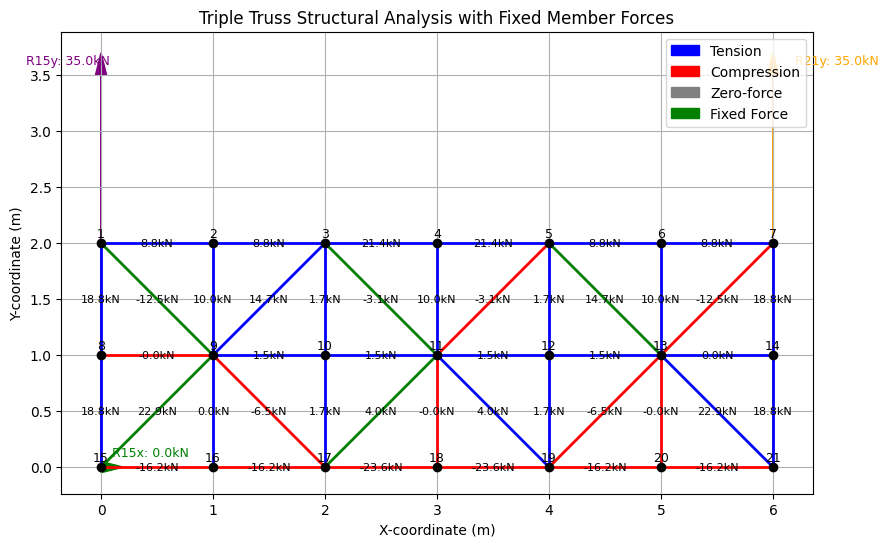


Total Volume of the Structure: 488.30 cubic units

Volume of Each Member:
Member    Start Node     End Node       Volume         
-------------------------------------------------------
Member 1     1             2             8.82         
Member 2     2             3             8.82         
Member 3     3             4             21.42        
Member 4     4             5             21.42        
Member 5     5             6             8.82         
Member 6     6             7             8.82         
Member 7     8             9             0.00         
Member 8     9             10            1.51         
Member 9     10            11            1.51         
Member 10    11            12            1.51         
Member 11    12            13            1.51         
Member 12    13            14            0.00         
Member 13    15            16            16.18        
Member 14    16            17            16.18        
Member 15    17            18            23

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ------------- 1. Define the Nodes -------------

# Initialize nodes dictionary
nodes = {}
node_id = 1

# Create 7 columns (x=0 to 6) and 3 rows (y=2 to 0)
for y in range(2, -1, -1):  # y=2 (top) to y=0 (bottom)
    for x in range(7):       # x=0 to x=6
        nodes[node_id] = (x, y)
        node_id += 1

# ------------- 2. Define the Members -------------

# Reset members dictionary
members = {}
member_id = 1

# Function to add a member between two nodes with validation
def add_member(start, end):
    global member_id
    # Check if both start and end nodes exist
    if start in nodes and end in nodes:
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any((start == existing_start and end == existing_end) or
                   (start == existing_end and end == existing_start)
                   for existing_start, existing_end in members.values()):
            members[member_id] = (start, end)
            member_id += 1
    else:
        print(f"Skipping member ({start}, {end}) - Invalid node number.")

# ------------- Add Horizontal Members -------------
# Top Row: Nodes 1-7
for i in range(1, 7):
    add_member(i, i+1)

# Middle Row: Nodes 8-14
for i in range(8, 14):
    add_member(i, i+1)

# Bottom Row: Nodes 15-21
for i in range(15, 21):
    add_member(i, i+1)

# ------------- Add Vertical Members -------------
# Columns 1 to 7: Connect top to middle to bottom
for col in range(1, 8):
    top_node = col
    middle_node = col + 7
    bottom_node = col + 14
    add_member(top_node, middle_node)
    add_member(middle_node, bottom_node)

# ------------- Add Diagonal Members at Middle Nodes 9, 11, 13 -------------

# Define middle nodes where diagonals will be added
middle_nodes = [9, 11, 13]

# Directions: up-left, up-right, down-left, down-right
directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

for node in middle_nodes:
    x, y = nodes[node]
    for dx, dy in directions:
        diag_x = x + dx
        diag_y = y + dy
        # Find the node that matches (diag_x, diag_y)
        diag_node = None
        for nid, coord in nodes.items():
            if coord == (diag_x, diag_y):
                diag_node = nid
                break
        if diag_node:
            add_member(node, diag_node)

# ------------- 3. Define Support Reactions -------------

# Supports are at Node 15 (pin: R15x, R15y) and Node 21 (roller: R21y)
support_reactions = {
    'R15x': None,   # Reaction at Node 15 in x-direction
    'R15y': None,   # Reaction at Node 15 in y-direction
    'R21y': None    # Reaction at Node 21 in y-direction
}

num_reactions = len(support_reactions)  # 3 reactions

# ------------- 4. Initialize the System of Equilibrium Equations -------------

num_members = len(members)       # Number of members (44)
num_nodes = len(nodes)           # 21 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 42 equations

total_unknowns = num_members + num_reactions  # 44 + 3 = 47 unknowns

# ------------- 5. Define External Loads -------------

# Evenly distributed downward loads on top nodes (Nodes 1 to 7)
external_loads = {}
load_magnitude = 10  # kN per node

for node in range(1, 8):  # Nodes 1 to 7
    external_loads[node] = (0, -load_magnitude)  # (Fx, Fy)

# ------------- 6. Define Direction Cosines -------------

def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    delta_x = x2 - x1
    delta_y = y2 - y1
    length = np.sqrt(delta_x**2 + delta_y**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = delta_x / length
    sin_theta = delta_y / length
    return cos_theta, sin_theta

# ------------- 7. Define Fixed Member Forces -------------

# Fixed member forces (Member ID: Force Value)
fixed_member_forces = {
    33: -12.474431,   # Member from Node 9 to Node 1
    35: 22.880908,    # Member from Node 9 to Node 15
    37: -3.068577,    # Member from Node 11 to Node 3
    39: 4.002491,     # Member from Node 11 to Node 17
    41: 14.742509     # Member from Node 13 to Node 5
}

# Zero-based indices of fixed member forces
fixed_member_indices = [m - 1 for m in fixed_member_forces.keys()]

# ------------- 8. Create Mapping for Unknown Indices -------------

# List of member indices (0-based) that are unknowns
unknown_member_indices = [i for i in range(num_members) if i not in fixed_member_indices]

# Total unknowns after removing fixed member forces
num_unknowns = len(unknown_member_indices) + num_reactions  # 39 + 3 = 42 unknowns

# Create a mapping from member index to unknown index
member_index_to_unknown = {}
unknown_index = 0
for i in range(num_members):
    if i not in fixed_member_indices:
        member_index_to_unknown[i] = unknown_index
        unknown_index += 1
# Map reactions to unknown indices
reaction_indices = range(num_unknowns - num_reactions, num_unknowns)

# ------------- 9. Initialize the Coefficient Matrix A and Load Vector B -------------

A = np.zeros((total_equations, num_unknowns))  # 42x42
B = np.zeros(total_equations)                  # 42-element vector

# ------------- 10. Populate the Coefficient Matrix A and Load Vector B -------------

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] += load[0]  # External load in x-direction
    B[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        member_index = m - 1  # Zero-based index
        if node == start or node == end:
            # Always calculate direction cosines from start to end
            try:
                cos_theta, sin_theta = direction_cosines(start, end)
            except ValueError as ve:
                print(ve)
                continue

            # Determine the sign of the coefficients based on node position
            if node == start:
                coef_x = cos_theta
                coef_y = sin_theta
            else:  # node == end
                coef_x = -cos_theta
                coef_y = -sin_theta

            if member_index in fixed_member_indices:
                # Subtract the fixed member force contribution from B
                fixed_force = fixed_member_forces[m]
                B[eq_x] -= coef_x * fixed_force
                B[eq_y] -= coef_y * fixed_force
            else:
                # Add coefficients to A matrix
                unknown_idx = member_index_to_unknown[member_index]
                A[eq_x, unknown_idx] += coef_x
                A[eq_y, unknown_idx] += coef_y

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A[eq_x, num_unknowns - num_reactions + 0] -= 1   # R15x
        A[eq_y, num_unknowns - num_reactions + 1] -= 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A[eq_y, num_unknowns - num_reactions + 2] -= 1   # R21y

# ------------- 11. Solve the System -------------

# Solve the system A * F_unknowns = B
try:
    F_unknowns = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible, use least squares
    F_unknowns, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# ------------- 12. Reconstruct the Full Solution Vector F -------------

F_full = np.zeros(total_unknowns)  # 47-element vector (44 members + 3 reactions)

# Insert the solved unknown member forces into F_full
for member_index in unknown_member_indices:
    unknown_idx = member_index_to_unknown[member_index]
    F_full[member_index] = F_unknowns[unknown_idx]

# Insert the fixed member forces into F_full
for m, force in fixed_member_forces.items():
    member_index = m - 1  # Zero-based index
    F_full[member_index] = force

# Insert reaction forces into F_full
for i in range(num_reactions):
    F_full[num_members + i] = F_unknowns[num_unknowns - num_reactions + i]

# Extract member forces and reaction forces
member_forces = F_full[:num_members]
reaction_forces = F_full[num_members:]

# ------------- 13. Display the Results -------------

# Display fixed member forces
print("Fixed Member Forces (in kN):")
for m, force in fixed_member_forces.items():
    start, end = members[m]
    print(f"Member {m} (Node {start} to Node {end}): {force:.2f} kN")

print("\nMember Forces (in kN):")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
print("-" * 70)
for m in members:
    start, end = members[m]
    force = member_forces[m - 1]
    if m in fixed_member_forces:
        status = "Fixed"
    else:
        if force > 0:
            status = "Tension"
        elif force < 0:
            status = "Compression"
        else:
            status = "Zero-force"
    print(f"Member {m:<5} {start:<13} {end:<13} {force:<13.2f} {status:<15}")

# Display support reactions
print("\nSupport Reactions (in kN):")
for i, reaction in enumerate(support_reactions):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.2f} kN")

# ------------- 14. Check Equilibrium -------------

# Reconstruct B using the full F vector
A_full = np.zeros((total_equations, total_unknowns))
B_full = np.zeros(total_equations)

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B_full[eq_x] += load[0]  # External load in x-direction
    B_full[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        member_index = m - 1  # Zero-based index
        if node == start or node == end:
            # Always calculate direction cosines from start to end
            try:
                cos_theta, sin_theta = direction_cosines(start, end)
            except ValueError as ve:
                print(ve)
                continue

            # Determine the sign of the coefficients based on node position
            if node == start:
                coef_x = cos_theta
                coef_y = sin_theta
            else:  # node == end
                coef_x = -cos_theta
                coef_y = -sin_theta

            A_full[eq_x, member_index] += coef_x
            A_full[eq_y, member_index] += coef_y

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A_full[eq_x, num_members + 0] -= 1   # R15x
        A_full[eq_y, num_members + 1] -= 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A_full[eq_y, num_members + 2] -= 1   # R21y

# Check equilibrium
B_calculated = np.dot(A_full, F_full)
difference = B_calculated - B_full
tolerance = 1e-6
if np.all(np.abs(difference) < tolerance):
    print("\nEquilibrium is satisfied.")
else:
    print("\nEquilibrium is NOT satisfied. Check the calculations.")
    # For debugging, print the maximum difference
    max_diff = np.max(np.abs(difference))
    print(f"Maximum difference: {max_diff}")

# ------------- 15. Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if m in fixed_member_forces:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='black',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    plt.arrow(x15, y15, reaction_forces[0]/10, 0, head_width=0.1, head_length=0.2, fc='green', ec='green')
    plt.text(x15 + reaction_forces[0]/10 + 0.1, y15 + 0.1, f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    plt.arrow(x15, y15, 0, reaction_forces[1]/10, head_width=0.1, head_length=0.2, fc='purple', ec='purple')
    plt.text(x15 - 0.3, y15 + reaction_forces[1]/10 + 0.1, f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    plt.arrow(x21, y21, 0, reaction_forces[2]/10, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
    plt.text(x21 + 0.2, y21 + reaction_forces[2]/10 + 0.1, f"R21y: {reaction_forces[2]:.1f}kN", color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Call the plotting function with the updated structure
plot_truss(nodes, members, member_forces, reaction_forces, title="Triple Truss Structural Analysis with Fixed Member Forces")

# ------------- 16. Calculate Total Volume of the Structure -------------

material_stress = 1  # Given material stress
total_volume = 0.0   # Initialize total volume

# Dictionary to store volume of each member
member_volumes = {}

for m in members:
    start_node, end_node = members[m]
    x1, y1 = nodes[start_node]
    x2, y2 = nodes[end_node]
    # Calculate length of the member
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    # Get the force in the member
    force = member_forces[m - 1]
    # Obtain magnitude of the force
    force_magnitude = abs(force)
    # Calculate cross-sectional area (A = |F| / σ)
    cross_sectional_area = force_magnitude / material_stress
    # Calculate volume (V = A * L)
    volume = cross_sectional_area * length
    # Add to total volume
    total_volume += volume
    # Store volume of the member
    member_volumes[m] = volume

# Display the total volume
print(f"\nTotal Volume of the Structure: {total_volume:.2f} cubic units")

# Optionally, display volume per member
print("\nVolume of Each Member:")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Volume':<15}")
print("-" * 55)
for m in member_volumes:
    start, end = members[m]
    volume = member_volumes[m]
    print(f"Member {m:<5} {start:<13} {end:<13} {volume:<13.2f}")



## Triple cell - GA applied to the fixed force values to find minimum volume

* Seed set as the same as the output for the equilibrium solver (as we know these values will provide a solution in equilibrium). The range of values that give an optimum solution are small so optimisation steps of +/- 0.001 are set

#### **Detailed Mathematical Explanation**

#### **Initialisation**

**Seed Values**: The original fixed member forces serve as the seed.

**Population Initialization**: Each gene in an individual is initialised: Each gene in an individual is initialized within a small range around the seed value, specifically within

$
[F_{\text{seed},j} - 0.001, \; F_{\text{seed},j} + 0.001]
$

Mathematically, for each gene $\left(g_j\right)$:

$
g_j(k) \sim U\left(F_{\text{seed},j} - 0.001, \; F_{\text{seed},j} + 0.001\right)
$

Where:

$
g_j(k) = \text{Value of gene } j \text{ in individual } k
$
$
U(a, b) = \text{Uniform distribution between } a \text{ and } b
$

#### **Fitness Evaluation**

For each individual $\left(k\right)$:

**Fixed Member Forces**: $\left( F_j(k) \right)$ for the five fixed members.

**Compute** $\left(V_{\text{total}}(k)\right)$: Using the truss analysis described earlier.

#### **Fitness Score**:

$
f(k) = V_{\text{total}}(k)
$

The lower the $\left(f(k)\right)$, the better the individual.

#### **Selection: Tournament Selection**

To select individuals for reproduction:

**Tournament Size** $\left(s\right)$: Number of individuals randomly chosen from the population.

**Winner Selection**: The individual with the lowest fitness score (i.e., lowest volume) in the tournament is selected.

Mathematically, for each selection event:

$
\text{Selected Individual} = \arg\min_{k \in S} f(k)
$

Where:

$
S = \text{Random subset of } s \text{ individuals from the population}
$

#### **Crossover: Single-point Crossover**

To create offspring:

**Crossover Probability** $\left(p_c\right)$: Probability that crossover occurs between two parents.

**Crossover Point** $\left(c\right)$: Randomly selected gene position where the crossover happens.

Mathematically, given two parent individuals $\left(P_1\right)$ and $\left(P_2\right)$:

$
\text{Child}_1 = \{g_1^{(1)}, \dots, g_c^{(1)}, g_{c+1}^{(2)}, \dots, g_n^{(2)}\}
$

$
\text{Child}_2 = \{g_1^{(2)}, \dots, g_c^{(2)}, g_{c+1}^{(1)}, \dots, g_n^{(1)}\}
$

With probability $\left(p_c\right)$, else:

$
\text{Child}_1 = P_1 \quad \text{and} \quad \text{Child}_2 = P_2
$

#### **Mutation**

To introduce diversity and avoid premature convergence:

**Mutation Probability** $\left(p_m\right)$: Probability that a gene undergoes mutation.

**Mutation Amount** $\left(\Delta\right)$: Small value added or subtracted to/from the gene.

Mathematically, for each gene $\left(g_j(k)\right)$ in individual $\left(k\right)$:

$
g_j(k) \leftarrow g_j(k) + \Delta \quad \text{where} \quad \Delta \sim U(-0.001, +0.001)
$

Subject to:

$
F_{\text{seed},j} - 0.001 \leq g_j(k) \leq F_{\text{seed},j} + 0.001
$

#### **Iterative Optimization**

The GA repeats the following steps for a set number of generations:

1. Evaluate Fitness for all individuals.
2. Select the best individuals via Tournament Selection.
3. Crossover selected parents to create offspring.
4. Mutate offspring genes.
5. Form New Population from offspring.
6. Record Best Individual if improved.

Mathematically, this can be viewed as navigating the search space to find the minimum of the fitness function:

$
f(\mathbf{F}) = V_{\text{total}}
$

#### **Total Volume Calculation**

The total volume $\left(V_{\text{total}}\right)$ is the sum of the volumes of all members:

$
V_{\text{total}} = \sum_{i=1}^{m} V_i = \sum_{i=1}^{m} \left( \frac{|F_i|}{\sigma} \cdot L_i \right)
$

Where:
$
m = \text{Total number of members}
$

#### **Explanation of the Mathematical Concepts**

**Initialisation**

**Seed Values**: These are the starting points for the fixed member forces. They represent the initial guess or known values from which the optimization begins.

**Population Initialization**: Each individual in the population represents a potential solution with specific fixed member forces. By initialising each gene within $\left(\pm 0.001\right)$ of the seed value, we ensure that the search starts in the vicinity of the original solution, allowing for fine-tuning.

**Fitness Evaluation**

**Fixed Member Forces**: These are the variables being optimised: These are the variables being optimized. By adjusting these forces, we aim to find the configuration that minimizes the total volume.

**Compute** $\left(V_{\text{total}}(k)\right)$: For each individual, we calculate the total volume based on the current set of fixed member forces and the resulting member forces from the truss analysis.

**Fitness Score**: The fitness score is directly proportional to the total volume. Since we aim to minimize volume, a lower fitness score indicates a better individual.

**Selection: Tournament Selection**

**Tournament Size** $\left(s\right)$: This parameter controls the selection pressure. A larger tournament size increases the likelihood of selecting fitter individuals.

**Winner Selection**: By selecting the individual with the lowest fitness score within each tournament, we ensure that better-performing individuals have a higher chance of passing their genes to the next generation.

**Crossover: Single-point Crossover**

**Crossover Probability** $\left(p_c\right)$: Determines how often crossover occurs. A higher probability means more offspring will be combinations of parents.

**Crossover Point** $\left(c\right)$: The gene position where the crossover happens. This allows mixing of genetic material from two parents to create new offspring.

**Mutation**

**Mutation Probability** $\left(p_m\right)$: Introduces randomness into the population, preventing premature convergence to local minima.

**Mutation Amount** $\left(\Delta\right)$: A small perturbation ensures that mutations are subtle, allowing the GA to explore the search space gradually.

**Iterative Optimisation**

**Generations**: Each generation represents an iteration where the population evolves towards better solutions.

**Recording Best Individual**: Keeping track of the best solution ensures that the GA does not lose the optimal solution found so far, even if subsequent generations do not improve upon it.


Original Fixed Member Forces:
  Member 33: -12.474431 kN
  Member 35: 22.880908 kN
  Member 37: -3.068577 kN
  Member 39: 4.002491 kN
  Member 41: 14.742509 kN
Starting Genetic Algorithm to Optimize Fixed Member Forces...
Generation 0: New Best Volume = 488.2877 cubic units
Current Fixed Member Forces:
  Member 33: -12.473550 kN
  Member 35: 22.880273 kN
  Member 37: -3.069384 kN
  Member 39: 4.002819 kN
  Member 41: 14.743134 kN
--------------------------------------------------
Generation 1: New Best Volume = 488.2847 cubic units
Current Fixed Member Forces:
  Member 33: -12.473490 kN
  Member 35: 22.880101 kN
  Member 37: -3.067577 kN
  Member 39: 4.003345 kN
  Member 41: 14.742700 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.2811 cubic units
Current Fixed Member Forces:
  Member 33: -12.473490 kN
  Member 35: 22.880101 kN
  Member 37: -3.067577 kN
  Member 39: 4.003345 kN
  Member 41: 14.743509 kN
----------------------------------------

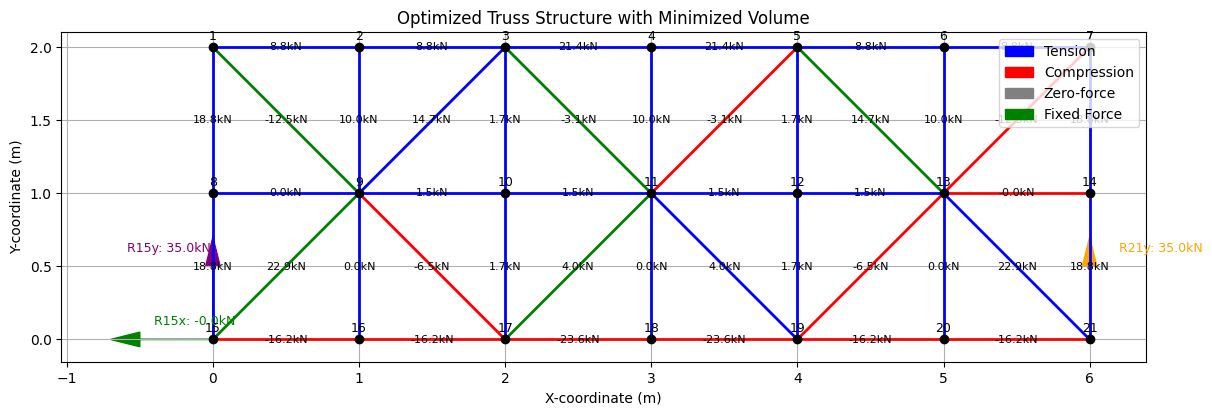

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import copy

# ------------------------- Part 1: Setup and Modularization -------------------------

# ------------- 1. Define the Nodes -------------

# Initialize nodes dictionary
nodes = {}
node_id = 1

# Create 7 columns (x=0 to 6) and 3 rows (y=2 to 0)
for y in range(2, -1, -1):  # y=2 (top) to y=0 (bottom)
    for x in range(7):       # x=0 to x=6
        nodes[node_id] = (x, y)
        node_id += 1

# ------------- 2. Define the Members -------------

# Reset members dictionary
members = {}
member_id = 1

# Function to add a member between two nodes with validation
def add_member(start, end):
    global member_id
    # Check if both start and end nodes exist
    if start in nodes and end in nodes:
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any((start == existing_start and end == existing_end) or
                   (start == existing_end and end == existing_start)
                   for existing_start, existing_end in members.values()):
            members[member_id] = (start, end)
            member_id += 1
    else:
        print(f"Skipping member ({start}, {end}) - Invalid node number.")

# ------------- Add Horizontal Members -------------
# Top Row: Nodes 1-7
for i in range(1, 7):
    add_member(i, i+1)

# Middle Row: Nodes 8-14
for i in range(8, 14):
    add_member(i, i+1)

# Bottom Row: Nodes 15-21
for i in range(15, 21):
    add_member(i, i+1)

# ------------- Add Vertical Members -------------
# Columns 1 to 7: Connect top to middle to bottom
for col in range(1, 8):
    top_node = col
    middle_node = col + 7
    bottom_node = col + 14
    add_member(top_node, middle_node)
    add_member(middle_node, bottom_node)

# ------------- Add Diagonal Members at Middle Nodes 9, 11, 13 -------------

# Define middle nodes where diagonals will be added
middle_nodes = [9, 11, 13]

# Directions: up-left, up-right, down-left, down-right
directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

for node in middle_nodes:
    x, y = nodes[node]
    for dx, dy in directions:
        diag_x = x + dx
        diag_y = y + dy
        # Find the node that matches (diag_x, diag_y)
        diag_node = None
        for nid, coord in nodes.items():
            if coord == (diag_x, diag_y):
                diag_node = nid
                break
        if diag_node:
            add_member(node, diag_node)

# ------------- 3. Define Support Reactions -------------

# Supports are at Node 15 (pin: R15x, R15y) and Node 21 (roller: R21y)
support_reactions = {
    'R15x': None,   # Reaction at Node 15 in x-direction
    'R15y': None,   # Reaction at Node 15 in y-direction
    'R21y': None    # Reaction at Node 21 in y-direction
}

num_reactions = len(support_reactions)  # 3 reactions

# ------------- 4. Initialize the System of Equilibrium Equations -------------

num_members = len(members)       # Number of members (44)
num_nodes = len(nodes)           # 21 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 42 equations

total_unknowns = num_members + num_reactions  # 44 + 3 = 47 unknowns

# ------------- 5. Define External Loads -------------

# Evenly distributed downward loads on top nodes (Nodes 1 to 7)
external_loads = {}
load_magnitude = 10  # kN per node

for node in range(1, 8):  # Nodes 1 to 7
    external_loads[node] = (0, -load_magnitude)  # (Fx, Fy)

# ------------- 6. Define Direction Cosines -------------

def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    delta_x = x2 - x1
    delta_y = y2 - y1
    length = np.sqrt(delta_x**2 + delta_y**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = delta_x / length
    sin_theta = delta_y / length
    return cos_theta, sin_theta

# ------------- 7. Define Fixed Member Forces -------------

# Fixed member forces (Member ID: Force Value)
seed_fixed_member_forces = {
    33: -12.474431,   # Member from Node 9 to Node 1
    35: 22.880908,    # Member from Node 9 to Node 15
    37: -3.068577,    # Member from Node 11 to Node 3
    39: 4.002491,     # Member from Node 11 to Node 17
    41: 14.742509     # Member from Node 13 to Node 5
}

# ------------- 8. Create Mapping for Unknown Indices -------------

# List of member indices (0-based) that are fixed
fixed_member_indices = [m - 1 for m in seed_fixed_member_forces.keys()]
unknown_member_indices = [i for i in range(num_members) if i not in fixed_member_indices]

# Total unknowns after removing fixed member forces
num_unknowns = len(unknown_member_indices) + num_reactions  # 39 + 3 = 42 unknowns

# Create a mapping from member index to unknown index
member_index_to_unknown = {}
unknown_index = 0
for i in range(num_members):
    if i not in fixed_member_indices:
        member_index_to_unknown[i] = unknown_index
        unknown_index += 1
# Map reactions to unknown indices
reaction_indices = range(num_unknowns - num_reactions, num_unknowns)

# ------------- 9. Compute Total Volume Function -------------

def compute_total_volume(current_fixed_member_forces):
    """
    Computes the total volume of the truss structure given the current fixed member forces.

    Parameters:
    - current_fixed_member_forces: dict mapping member IDs to force values.

    Returns:
    - total_volume: float, total volume of the structure.
    """
    # Initialize the Coefficient Matrix A and Load Vector B
    A = np.zeros((total_equations, num_unknowns))  # 42x42
    B = np.zeros(total_equations)                  # 42-element vector

    # Populate the Coefficient Matrix A and Load Vector B
    for node in nodes:
        # Equation indices
        eq_x = (node - 1) * 2      # Sum Fx
        eq_y = eq_x + 1            # Sum Fy

        # Assign external loads to B
        load = external_loads.get(node, (0, 0))
        B[eq_x] += load[0]  # External load in x-direction
        B[eq_y] += load[1]  # External load in y-direction

        # Iterate through all members to see if they are connected to the current node
        for m in members:
            start, end = members[m]
            member_index = m - 1  # Zero-based index
            if node == start or node == end:
                # Always calculate direction cosines from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue

                # Determine the sign of the coefficients based on node position
                if node == start:
                    coef_x = cos_theta
                    coef_y = sin_theta
                else:  # node == end
                    coef_x = -cos_theta
                    coef_y = -sin_theta

                if m in current_fixed_member_forces:
                    # Subtract the fixed member force contribution from B
                    fixed_force = current_fixed_member_forces[m]
                    B[eq_x] -= coef_x * fixed_force
                    B[eq_y] -= coef_y * fixed_force
                else:
                    # Add coefficients to A matrix
                    if member_index in member_index_to_unknown:
                        unknown_idx = member_index_to_unknown[member_index]
                        A[eq_x, unknown_idx] += coef_x
                        A[eq_y, unknown_idx] += coef_y

        # Assign support reactions to the equations if the node has a support
        if node == 15:
            # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
            A[eq_x, num_unknowns - num_reactions + 0] -= 1   # R15x
            A[eq_y, num_unknowns - num_reactions + 1] -= 1   # R15y
        if node == 21:
            # Reaction R21y affects Sum Fy at Node 21
            A[eq_y, num_unknowns - num_reactions + 2] -= 1   # R21y

    # Solve the System
    try:
        F_unknowns = np.linalg.solve(A, B)
        equilibrium_satisfied = True
    except np.linalg.LinAlgError:
        # If A is singular or not invertible, use least squares
        F_unknowns, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
        equilibrium_satisfied = False

    # Reconstruct the Full Solution Vector F
    F_full = np.zeros(total_unknowns)  # 42-element vector (39 members + 3 reactions)

    # Insert the solved unknown member forces into F_full
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        F_full[unknown_idx] = F_unknowns[unknown_idx]

    # Insert reaction forces into F_full
    for i in range(num_reactions):
        F_full[num_unknowns - num_reactions + i] = F_unknowns[num_unknowns - num_reactions + i]

    # Extract member forces and reaction forces
    member_forces = np.zeros(num_members)
    # Insert fixed member forces
    for m, force in current_fixed_member_forces.items():
        member_index = m - 1  # Zero-based index
        member_forces[member_index] = force
    # Insert unknown member forces
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        member_forces[member_index] = F_unknowns[unknown_idx]
    # Reaction forces are not used in volume calculation

    # ------------- 14. Calculate Total Volume of the Structure -------------

    material_stress = 1  # Given material stress
    total_volume = 0.0   # Initialize total volume

    # Dictionary to store volume of each member
    member_volumes = {}

    for m in members:
        start_node, end_node = members[m]
        x1, y1 = nodes[start_node]
        x2, y2 = nodes[end_node]
        # Calculate length of the member
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        # Get the force in the member
        force = member_forces[m - 1]
        # Obtain magnitude of the force
        force_magnitude = abs(force)
        # Calculate cross-sectional area (A = |F| / σ)
        cross_sectional_area = force_magnitude / material_stress
        # Calculate volume (V = A * L)
        volume = cross_sectional_area * length
        # Add to total volume
        total_volume += volume
        # Store volume of the member
        member_volumes[m] = volume

    return total_volume

# ------------------------- Part 2: Genetic Algorithm Implementation -------------------------

# Genetic Algorithm Parameters
POPULATION_SIZE = 50
GENERATIONS = 100
TOURNAMENT_SIZE = 3
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MUTATION_AMOUNT = 0.001  # Maximum mutation per gene

# Define the genes (fixed member forces)
fixed_member_ids = sorted(seed_fixed_member_forces.keys())
seed_genes = [seed_fixed_member_forces[m] for m in fixed_member_ids]

# Define gene bounds (±0.001 from seed)
gene_bounds = [(force - 0.001, force + 0.001) for force in seed_genes]

# Initialize Population
def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = []
        for i, (low, high) in enumerate(gene_bounds):
            gene = random.uniform(low, high)
            individual.append(gene)
        population.append(individual)
    return population

# Fitness Function: Minimize total volume
def fitness(individual):
    current_fixed_member_forces = {m: individual[i] for i, m in enumerate(fixed_member_ids)}
    total_vol = compute_total_volume(current_fixed_member_forces)
    return total_vol  # Removed the trailing comma to return a float

# Selection: Tournament Selection
def tournament_selection(pop, scores):
    selected = []
    for _ in range(POPULATION_SIZE):
        aspirants = random.sample(range(len(pop)), TOURNAMENT_SIZE)
        aspirant_scores = [scores[i] for i in aspirants]
        winner = aspirants[np.argmin(aspirant_scores)]
        selected.append(copy.deepcopy(pop[winner]))
    return selected

# Crossover: Single-point Crossover
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1)-1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    else:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# Mutation: Add or subtract a small value
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            mutation = random.uniform(-MUTATION_AMOUNT, MUTATION_AMOUNT)
            individual[i] += mutation
            # Ensure gene is within bounds
            individual[i] = max(gene_bounds[i][0], min(individual[i], gene_bounds[i][1]))
    return individual

# Genetic Algorithm Main Loop
def genetic_algorithm():
    population = initialize_population()
    best_volume = float('inf')
    best_individual = None

    for gen in range(GENERATIONS):
        # Evaluate fitness
        scores = [fitness(ind) for ind in population]
        # Find the best individual in current generation
        min_score = min(scores)
        min_index = scores.index(min_score)
        current_best_individual = population[min_index]
        current_best_volume = min_score

        # Check if the current best is better than the global best
        if current_best_volume < best_volume:
            best_volume = current_best_volume
            best_individual = copy.deepcopy(current_best_individual)
            print(f"Generation {gen}: New Best Volume = {best_volume:.4f} cubic units")
            print("Current Fixed Member Forces:")
            for i, m in enumerate(fixed_member_ids):
                print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
            print("-" * 50)

        # Selection
        selected = tournament_selection(population, scores)

        # Create next generation
        next_generation = []
        for i in range(0, POPULATION_SIZE, 2):
            parent1 = selected[i]
            if i+1 < POPULATION_SIZE:
                parent2 = selected[i+1]
            else:
                parent2 = selected[0]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation[:POPULATION_SIZE]

    return best_individual, best_volume

# ------------------------- Part 3: Execution and Results -------------------------

# Print Original Fixed Member Forces
print("Original Fixed Member Forces:")
for m in fixed_member_ids:
    force = seed_fixed_member_forces[m]
    print(f"  Member {m}: {force:.6f} kN")
print("=" * 50)

# Run Genetic Algorithm
print("Starting Genetic Algorithm to Optimize Fixed Member Forces...")
best_forces, best_volume = genetic_algorithm()
print("\nOptimization Complete!")
print(f"Best Total Volume: {best_volume:.4f} cubic units")
print("Best Fixed Member Forces:")
for i, m in enumerate(fixed_member_ids):
    print(f"  Member {m}: {best_forces[i]:.6f} kN")

# Optional: Visualize the Optimized Truss
def visualize_truss(current_fixed_member_forces, title="Optimized Truss Structure"):
    # Initialize the Coefficient Matrix A and Load Vector B
    A = np.zeros((total_equations, num_unknowns))  # 42x42
    B = np.zeros(total_equations)                  # 42-element vector

    # Populate the Coefficient Matrix A and Load Vector B
    for node in nodes:
        # Equation indices
        eq_x = (node - 1) * 2      # Sum Fx
        eq_y = eq_x + 1            # Sum Fy

        # Assign external loads to B
        load = external_loads.get(node, (0, 0))
        B[eq_x] += load[0]  # External load in x-direction
        B[eq_y] += load[1]  # External load in y-direction

        # Iterate through all members to see if they are connected to the current node
        for m in members:
            start, end = members[m]
            member_index = m - 1  # Zero-based index
            if node == start or node == end:
                # Always calculate direction cosines from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue

                # Determine the sign of the coefficients based on node position
                if node == start:
                    coef_x = cos_theta
                    coef_y = sin_theta
                else:  # node == end
                    coef_x = -cos_theta
                    coef_y = -sin_theta

                if m in current_fixed_member_forces:
                    # Subtract the fixed member force contribution from B
                    fixed_force = current_fixed_member_forces[m]
                    B[eq_x] -= coef_x * fixed_force
                    B[eq_y] -= coef_y * fixed_force
                else:
                    # Add coefficients to A matrix
                    if member_index in member_index_to_unknown:
                        unknown_idx = member_index_to_unknown[member_index]
                        A[eq_x, unknown_idx] += coef_x
                        A[eq_y, unknown_idx] += coef_y

        # Assign support reactions to the equations if the node has a support
        if node == 15:
            # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
            A[eq_x, num_unknowns - num_reactions + 0] -= 1   # R15x
            A[eq_y, num_unknowns - num_reactions + 1] -= 1   # R15y
        if node == 21:
            # Reaction R21y affects Sum Fy at Node 21
            A[eq_y, num_unknowns - num_reactions + 2] -= 1   # R21y

    # Solve the System
    try:
        F_unknowns = np.linalg.solve(A, B)
        equilibrium_satisfied = True
    except np.linalg.LinAlgError:
        # If A is singular or not invertible, use least squares
        F_unknowns, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
        equilibrium_satisfied = False

    # Reconstruct the Full Solution Vector F
    F_full = np.zeros(total_unknowns)  # 42-element vector (39 members + 3 reactions)

    # Insert the solved unknown member forces into F_full
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        F_full[unknown_idx] = F_unknowns[unknown_idx]

    # Insert reaction forces into F_full
    for i in range(num_reactions):
        F_full[num_unknowns - num_reactions + i] = F_unknowns[num_unknowns - num_reactions + i]

    # Extract member forces and reaction forces
    member_forces = np.zeros(num_members)
    # Insert fixed member forces
    for m, force in current_fixed_member_forces.items():
        member_index = m - 1  # Zero-based index
        member_forces[member_index] = force
    # Insert unknown member forces
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        member_forces[member_index] = F_unknowns[unknown_idx]
    # Reaction forces are not used in visualization

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if m in current_fixed_member_forces:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='black',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    if F_full[num_unknowns - num_reactions + 0] != 0:
        scale = 0.5  # Scale for visualization
        plt.arrow(x15, y15, scale * F_full[num_unknowns - num_reactions + 0]/abs(F_full[num_unknowns - num_reactions + 0]),
                  0, head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + scale * F_full[num_unknowns - num_reactions + 0]/abs(F_full[num_unknowns - num_reactions + 0]) + 0.1,
                 y15 + 0.1, f"R15x: {F_full[num_unknowns - num_reactions + 0]:.1f}kN",
                 color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if F_full[num_unknowns - num_reactions + 1] != 0:
        scale = 0.5  # Scale for visualization
        plt.arrow(x15, y15, 0, scale * F_full[num_unknowns - num_reactions + 1]/abs(F_full[num_unknowns - num_reactions + 1]),
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + scale * F_full[num_unknowns - num_reactions + 1]/abs(F_full[num_unknowns - num_reactions + 1]) + 0.1,
                 f"R15y: {F_full[num_unknowns - num_reactions + 1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    if F_full[num_unknowns - num_reactions + 2] != 0:
        scale = 0.5  # Scale for visualization
        plt.arrow(x21, y21, 0, scale * F_full[num_unknowns - num_reactions + 2]/abs(F_full[num_unknowns - num_reactions + 2]),
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + scale * F_full[num_unknowns - num_reactions + 2]/abs(F_full[num_unknowns - num_reactions + 2]) + 0.1,
                 f"R21y: {F_full[num_unknowns - num_reactions + 2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Visualize the optimized truss
optimized_fixed_member_forces = {m: best_forces[i] for i, m in enumerate(fixed_member_ids)}
visualize_truss(optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")


## Triple cell - degree of indeterminacy added

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12            13            1.509434      Tension        
Member 12    13            14            0.000000     

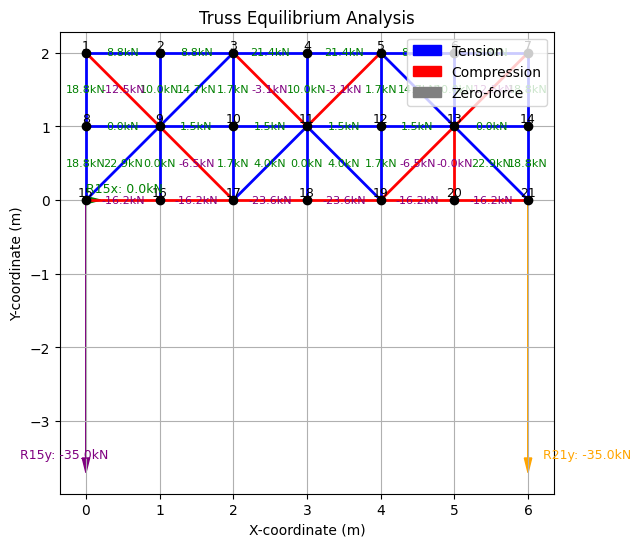


Original Fixed Member Forces:
  Member 33: -12.474431 kN
  Member 35: 22.880908 kN
  Member 37: -3.068577 kN
  Member 39: 4.002491 kN
  Member 41: 14.742509 kN
Starting Genetic Algorithm to Optimize Fixed Member Forces...
Generation 0: New Best Volume = 488.2880 cubic units
Current Fixed Member Forces:
  Member 33: -12.473734 kN
  Member 35: 22.879993 kN
  Member 37: -3.068550 kN
  Member 39: 4.001626 kN
  Member 41: 14.743319 kN
--------------------------------------------------
Generation 1: New Best Volume = 488.2874 cubic units
Current Fixed Member Forces:
  Member 33: -12.473514 kN
  Member 35: 22.880505 kN
  Member 37: -3.068228 kN
  Member 39: 4.002777 kN
  Member 41: 14.743177 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.2826 cubic units
Current Fixed Member Forces:
  Member 33: -12.473734 kN
  Member 35: 22.879993 kN
  Member 37: -3.067577 kN
  Member 39: 4.003422 kN
  Member 41: 14.743445 kN
---------------------------------------

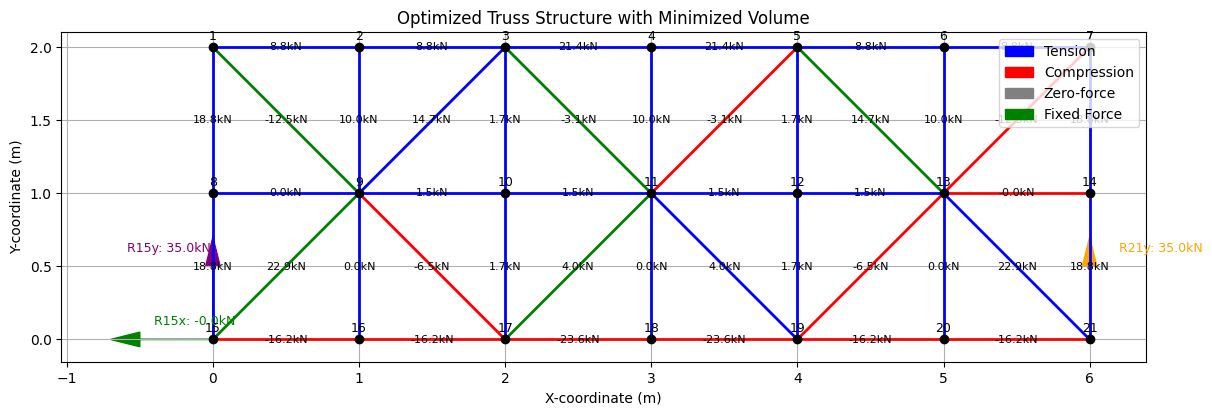

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import copy

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

# ------------- 1. Define the Nodes -------------

# Initialize nodes dictionary
nodes = {}
node_id = 1

# Create 7 columns (x=0 to 6) and 3 rows (y=2 to 0)
for y in range(2, -1, -1):  # y=2 (top) to y=0 (bottom)
    for x in range(7):       # x=0 to x=6
        nodes[node_id] = (x, y)
        node_id += 1

# ------------- 2. Define the Members -------------

# Reset members dictionary
members = {}
member_id = 1

# Function to add a member between two nodes with validation
def add_member(start, end):
    global member_id
    # Check if both start and end nodes exist
    if start in nodes and end in nodes:
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any((start == existing_start and end == existing_end) or
                   (start == existing_end and end == existing_start)
                   for existing_start, existing_end in members.values()):
            members[member_id] = (start, end)
            member_id += 1
    else:
        print(f"Skipping member ({start}, {end}) - Invalid node number.")

# ------------- Add Horizontal Members -------------
# Top Row: Nodes 1-7
for i in range(1, 7):
    add_member(i, i+1)

# Middle Row: Nodes 8-14
for i in range(8, 14):
    add_member(i, i+1)

# Bottom Row: Nodes 15-21
for i in range(15, 21):
    add_member(i, i+1)

# ------------- Add Vertical Members -------------
# Columns 1 to 7: Connect top to middle to bottom
for col in range(1, 8):
    top_node = col
    middle_node = col + 7
    bottom_node = col + 14
    add_member(top_node, middle_node)
    add_member(middle_node, bottom_node)

# ------------- Add Diagonal Members at Middle Nodes 9, 11, 13 -------------

# Define middle nodes where diagonals will be added
middle_nodes = [9, 11, 13]

# Directions: up-left, up-right, down-left, down-right
directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

for node in middle_nodes:
    x, y = nodes[node]
    for dx, dy in directions:
        diag_x = x + dx
        diag_y = y + dy
        # Find the node that matches (diag_x, diag_y)
        diag_node = None
        for nid, coord in nodes.items():
            if coord == (diag_x, diag_y):
                diag_node = nid
                break
        if diag_node:
            add_member(node, diag_node)

# ------------- 3. Define Support Reactions -------------

# Supports are at Node 15 (pin: R15x, R15y) and Node 21 (roller: R21y)
support_reactions = {
    'R15x': None,   # Reaction at Node 15 in x-direction
    'R15y': None,   # Reaction at Node 15 in y-direction
    'R21y': None    # Reaction at Node 21 in y-direction
}

num_reactions = len(support_reactions)  # 3 reactions

# ------------- 4. Initialize the System of Equilibrium Equations -------------

num_members = len(members)       # Number of members (should be 44)
num_nodes = len(nodes)           # 21 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 42 equations

total_unknowns = num_members + num_reactions  # 44 + 3 = 47 unknowns

# Initialize the coefficient matrix A and load vector B
A = np.zeros((total_equations, total_unknowns))  # 42x47
B = np.zeros(total_equations)                   # 42-element vector

# ------------- 5. Define External Loads -------------

# Evenly distributed downward loads on top nodes (Nodes 1 to 7)
external_loads = {}
load_magnitude = 10  # kN per node

for node in range(1, 8):  # Nodes 1 to 7
    external_loads[node] = (0, -load_magnitude)  # (Fx, Fy)

# ------------- 6. Define Direction Cosines -------------

def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    delta_x = x2 - x1
    delta_y = y2 - y1
    length = np.sqrt(delta_x**2 + delta_y**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = delta_x / length
    sin_theta = delta_y / length
    return cos_theta, sin_theta

# ------------- 7. Populate the Coefficient Matrix A and Load Vector B -------------

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] += load[0]  # External load in x-direction
    B[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        if node == start or node == end:
            # Determine the direction: outward (+) or inward (-)
            if node == start:
                # Member is going from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta
            else:
                # Member is going from end to start
                try:
                    cos_theta, sin_theta = direction_cosines(end, start)
                except ValueError as ve:
                    print(ve)
                    continue
                A[eq_x, m - 1] += cos_theta
                A[eq_y, m - 1] += sin_theta

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A[eq_x, num_members + 0] += 1   # R15x
        A[eq_y, num_members + 1] += 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A[eq_y, num_members + 2] += 1   # R21y

# ------------- 8. Solve the System -------------

# Solve the system A * F = B
try:
    F = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible, use least squares
    F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# Extract member forces and reaction forces
member_forces = F[:num_members]
reaction_forces = F[num_members:]

# ------------- 9. Display the Results -------------

# Display member forces with start and end nodes
print("Member Forces (in kN):")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
print("-" * 70)
for m in members:
    start, end = members[m]
    force = member_forces[m - 1]
    if force > 0:
        status = "Tension"
    elif force < 0:
        status = "Compression"
    else:
        status = "Zero-force"
    print(f"Member {m:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

# Display support reactions
print("\nSupport Reactions (in kN):")
for i, reaction in enumerate(support_reactions):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.6f} kN")

# Check equilibrium
if equilibrium_satisfied:
    print("\nEquilibrium is satisfied.")
else:
    B_calculated = np.dot(A, F)
    difference = B_calculated - B
    tolerance = 1e-7
    if np.all(np.abs(difference) < tolerance):
        print("\nEquilibrium is satisfied.")
    else:
        print("\nEquilibrium is NOT satisfied. Check the calculations.")

# ------------- 10. Calculate Degree of Indeterminacy -------------

degree_of_indeterminacy = len(members) + len(support_reactions) - 2 * len(nodes)
print(f"\nDegree of Indeterminacy: {degree_of_indeterminacy}")

# ------------- 11. Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if force > 0:
            color = tension_color
            linewidth = 2
        elif force < 0:
            color = compression_color
            linewidth = 2
        else:
            color = zero_color
            linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='green' if force > 0 else 'purple',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    plt.arrow(x15, y15, reaction_forces[0]/10, 0, head_width=0.1, head_length=0.2, fc='green', ec='green')
    plt.text(x15 + reaction_forces[0]/10, y15 + 0.1, f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    plt.arrow(x15, y15, 0, reaction_forces[1]/10, head_width=0.1, head_length=0.2, fc='purple', ec='purple')
    plt.text(x15 - 0.3, y15 + reaction_forces[1]/10, f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    plt.arrow(x21, y21, 0, reaction_forces[2]/10, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
    plt.text(x21 + 0.2, y21 + reaction_forces[2]/10, f"R21y: {reaction_forces[2]:.1f}kN", color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Call the plotting function with the initial truss
plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Equilibrium Analysis")

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

# ------------- 1. Define Fixed Member Forces -------------

# Fixed member forces (Member ID: Force Value)
# These are selected based on the equilibrium analysis
fixed_member_ids = [33, 35, 37, 39, 41]  # Members to be optimized
seed_fixed_member_forces = {
    m: member_forces[m - 1] for m in fixed_member_ids
}

# ------------- 2. Define Direction Cosines -------------

# Already defined above; reuse the same function

# ------------- 3. Create Mapping for Unknown Indices -------------

# List of member indices (0-based) that are fixed
fixed_member_indices = [m - 1 for m in fixed_member_ids]
unknown_member_indices = [i for i in range(num_members) if i not in fixed_member_indices]

# Total unknowns after removing fixed member forces
num_unknowns_ga = len(unknown_member_indices) + num_reactions  # 39 + 3 = 42 unknowns

# Create a mapping from member index to unknown index
member_index_to_unknown = {}
unknown_index = 0
for i in range(num_members):
    if i not in fixed_member_indices:
        member_index_to_unknown[i] = unknown_index
        unknown_index += 1

# ------------- 4. Compute Total Volume Function -------------

def compute_total_volume(current_fixed_member_forces):
    """
    Computes the total volume of the truss structure given the current fixed member forces.

    Parameters:
    - current_fixed_member_forces: dict mapping member IDs to force values.

    Returns:
    - total_volume: float, total volume of the structure.
    """
    # Initialize the Coefficient Matrix A and Load Vector B
    A_ga = np.zeros((total_equations, num_unknowns_ga))  # 42x42
    B_ga = np.zeros(total_equations)                  # 42-element vector

    # Populate the Coefficient Matrix A and Load Vector B
    for node in nodes:
        # Equation indices
        eq_x = (node - 1) * 2      # Sum Fx
        eq_y = eq_x + 1            # Sum Fy

        # Assign external loads to B
        load = external_loads.get(node, (0, 0))
        B_ga[eq_x] += load[0]  # External load in x-direction
        B_ga[eq_y] += load[1]  # External load in y-direction

        # Iterate through all members to see if they are connected to the current node
        for m in members:
            start, end = members[m]
            member_index = m - 1  # Zero-based index
            if node == start or node == end:
                # Always calculate direction cosines from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue

                # Determine the sign of the coefficients based on node position
                if node == start:
                    coef_x = cos_theta
                    coef_y = sin_theta
                else:  # node == end
                    coef_x = -cos_theta
                    coef_y = -sin_theta

                if m in current_fixed_member_forces:
                    # Subtract the fixed member force contribution from B
                    fixed_force = current_fixed_member_forces[m]
                    B_ga[eq_x] -= coef_x * fixed_force
                    B_ga[eq_y] -= coef_y * fixed_force
                else:
                    # Add coefficients to A matrix
                    if member_index in member_index_to_unknown:
                        unknown_idx = member_index_to_unknown[member_index]
                        A_ga[eq_x, unknown_idx] += coef_x
                        A_ga[eq_y, unknown_idx] += coef_y

        # Assign support reactions to the equations if the node has a support
        if node == 15:
            # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
            A_ga[eq_x, len(unknown_member_indices) + 0] -= 1   # R15x
            A_ga[eq_y, len(unknown_member_indices) + 1] -= 1   # R15y
        if node == 21:
            # Reaction R21y affects Sum Fy at Node 21
            A_ga[eq_y, len(unknown_member_indices) + 2] -= 1   # R21y

    # Solve the System
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
        equilibrium_satisfied_ga = True
    except np.linalg.LinAlgError:
        # If A is singular or not invertible, use least squares
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
        equilibrium_satisfied_ga = False

    # Reconstruct the Full Solution Vector F
    F_full_ga = np.zeros(num_members)  # 44-element vector (members)

    # Insert the solved unknown member forces into F_full_ga
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]

    # Insert fixed member forces into F_full_ga
    for m, force in current_fixed_member_forces.items():
        member_index = m - 1  # Zero-based index
        F_full_ga[member_index] = force

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # ------------- 14. Calculate Total Volume of the Structure -------------

    material_stress = 1  # Given material stress (kN/m²)
    total_volume = 0.0   # Initialize total volume

    # Dictionary to store volume of each member
    member_volumes = {}

    for m in members:
        start_node, end_node = members[m]
        x1, y1 = nodes[start_node]
        x2, y2 = nodes[end_node]
        # Calculate length of the member
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        # Get the force in the member
        force = F_full_ga[m - 1]
        # Obtain magnitude of the force
        force_magnitude = abs(force)
        # Calculate cross-sectional area (A = |F| / σ)
        cross_sectional_area = force_magnitude / material_stress
        # Calculate volume (V = A * L)
        volume = cross_sectional_area * length
        # Add to total volume
        total_volume += volume
        # Store volume of the member
        member_volumes[m] = volume

    return total_volume

# ------------- 5. Define Fixed Member Forces -------------

# These are the fixed member forces based on the equilibrium analysis
# Members 33, 35, 37, 39, 41
fixed_member_ids = [33, 35, 37, 39, 41]
seed_fixed_member_forces = {
    m: member_forces[m - 1] for m in fixed_member_ids
}

# ------------- 6. Define Gene Bounds -------------

# Define gene bounds (±0.001 from seed)
gene_bounds = [(force - 0.001, force + 0.001) for force in seed_fixed_member_forces.values()]

# ------------- 7. Initialize the System for Genetic Algorithm -------------

# List of member indices (0-based) that are fixed
fixed_member_indices = [m - 1 for m in fixed_member_ids]
unknown_member_indices = [i for i in range(num_members) if i not in fixed_member_indices]

# Total unknowns after removing fixed member forces
num_unknowns_ga = len(unknown_member_indices) + num_reactions  # 39 + 3 = 42 unknowns

# Create a mapping from member index to unknown index
member_index_to_unknown = {}
unknown_index = 0
for i in range(num_members):
    if i not in fixed_member_indices:
        member_index_to_unknown[i] = unknown_index
        unknown_index += 1

# ------------- 8. Define Genetic Algorithm Parameters -------------

# Genetic Algorithm Parameters
POPULATION_SIZE = 50
GENERATIONS = 100
TOURNAMENT_SIZE = 3
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MUTATION_AMOUNT = 0.001  # Maximum mutation per gene

# ------------- 9. Initialize Population -------------

def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = []
        for i, (low, high) in enumerate(gene_bounds):
            gene = random.uniform(low, high)
            individual.append(gene)
        population.append(individual)
    return population

# ------------- 10. Fitness Function -------------

def fitness(individual):
    current_fixed_member_forces = {m: individual[i] for i, m in enumerate(fixed_member_ids)}
    total_vol = compute_total_volume(current_fixed_member_forces)
    return total_vol  # Minimize total volume

# ------------- 11. Selection: Tournament Selection -------------

def tournament_selection(pop, scores):
    selected = []
    for _ in range(POPULATION_SIZE):
        aspirants = random.sample(range(len(pop)), TOURNAMENT_SIZE)
        aspirant_scores = [scores[i] for i in aspirants]
        winner = aspirants[np.argmin(aspirant_scores)]
        selected.append(copy.deepcopy(pop[winner]))
    return selected

# ------------- 12. Crossover: Single-point Crossover -------------

def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1)-1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    else:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------- 13. Mutation: Add or subtract a small value -------------

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            mutation = random.uniform(-MUTATION_AMOUNT, MUTATION_AMOUNT)
            individual[i] += mutation
            # Ensure gene is within bounds
            individual[i] = max(gene_bounds[i][0], min(individual[i], gene_bounds[i][1]))
    return individual

# ------------- 14. Genetic Algorithm Main Loop -------------

def genetic_algorithm():
    population = initialize_population()
    best_volume = float('inf')
    best_individual = None

    for gen in range(GENERATIONS):
        # Evaluate fitness
        scores = [fitness(ind) for ind in population]
        # Find the best individual in current generation
        min_score = min(scores)
        min_index = scores.index(min_score)
        current_best_individual = population[min_index]
        current_best_volume = min_score

        # Check if the current best is better than the global best
        if current_best_volume < best_volume:
            best_volume = current_best_volume
            best_individual = copy.deepcopy(current_best_individual)
            print(f"Generation {gen}: New Best Volume = {best_volume:.4f} cubic units")
            print("Current Fixed Member Forces:")
            for i, m in enumerate(fixed_member_ids):
                print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
            print("-" * 50)

        # Selection
        selected = tournament_selection(population, scores)

        # Create next generation
        next_generation = []
        for i in range(0, POPULATION_SIZE, 2):
            parent1 = selected[i]
            if i+1 < POPULATION_SIZE:
                parent2 = selected[i+1]
            else:
                parent2 = selected[0]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation[:POPULATION_SIZE]

    return best_individual, best_volume

# ------------- 15. Execution and Results -------------

# Print Original Fixed Member Forces
print("\nOriginal Fixed Member Forces:")
for m in fixed_member_ids:
    force = seed_fixed_member_forces[m]
    print(f"  Member {m}: {force:.6f} kN")
print("=" * 50)

# Run Genetic Algorithm
print("Starting Genetic Algorithm to Optimize Fixed Member Forces...")
best_forces, best_volume = genetic_algorithm()
print("\nOptimization Complete!")
print(f"Best Total Volume: {best_volume:.4f} cubic units")
print("Best Fixed Member Forces:")
for i, m in enumerate(fixed_member_ids):
    print(f"  Member {m}: {best_forces[i]:.6f} kN")

# ------------- 16. Visualize the Optimized Truss -------------

def visualize_truss(current_fixed_member_forces, title="Optimized Truss Structure"):
    # Initialize the Coefficient Matrix A and Load Vector B
    A_ga = np.zeros((total_equations, num_unknowns_ga))  # 42x42
    B_ga = np.zeros(total_equations)                  # 42-element vector

    # Populate the Coefficient Matrix A and Load Vector B
    for node in nodes:
        # Equation indices
        eq_x = (node - 1) * 2      # Sum Fx
        eq_y = eq_x + 1            # Sum Fy

        # Assign external loads to B
        load = external_loads.get(node, (0, 0))
        B_ga[eq_x] += load[0]  # External load in x-direction
        B_ga[eq_y] += load[1]  # External load in y-direction

        # Iterate through all members to see if they are connected to the current node
        for m in members:
            start, end = members[m]
            member_index = m - 1  # Zero-based index
            if node == start or node == end:
                # Always calculate direction cosines from start to end
                try:
                    cos_theta, sin_theta = direction_cosines(start, end)
                except ValueError as ve:
                    print(ve)
                    continue

                # Determine the sign of the coefficients based on node position
                if node == start:
                    coef_x = cos_theta
                    coef_y = sin_theta
                else:  # node == end
                    coef_x = -cos_theta
                    coef_y = -sin_theta

                if m in current_fixed_member_forces:
                    # Subtract the fixed member force contribution from B
                    fixed_force = current_fixed_member_forces[m]
                    B_ga[eq_x] -= coef_x * fixed_force
                    B_ga[eq_y] -= coef_y * fixed_force
                else:
                    # Add coefficients to A matrix
                    if member_index in member_index_to_unknown:
                        unknown_idx = member_index_to_unknown[member_index]
                        A_ga[eq_x, unknown_idx] += coef_x
                        A_ga[eq_y, unknown_idx] += coef_y

        # Assign support reactions to the equations if the node has a support
        if node == 15:
            # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
            A_ga[eq_x, len(unknown_member_indices) + 0] -= 1   # R15x
            A_ga[eq_y, len(unknown_member_indices) + 1] -= 1   # R15y
        if node == 21:
            # Reaction R21y affects Sum Fy at Node 21
            A_ga[eq_y, len(unknown_member_indices) + 2] -= 1   # R21y

    # Solve the System
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
        equilibrium_satisfied_ga = True
    except np.linalg.LinAlgError:
        # If A is singular or not invertible, use least squares
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
        equilibrium_satisfied_ga = False

    # Reconstruct the Full Solution Vector F
    F_full_ga = np.zeros(num_members)  # 44-element vector (members)

    # Insert the solved unknown member forces into F_full_ga
    for member_index in unknown_member_indices:
        unknown_idx = member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]

    # Insert fixed member forces into F_full_ga
    for m, force in current_fixed_member_forces.items():
        member_index = m - 1  # Zero-based index
        F_full_ga[member_index] = force

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Extract member forces
    member_forces_ga = F_full_ga

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces_ga[m - 1]

        # Determine color based on force
        if m in current_fixed_member_forces:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='black',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, scale * direction, 0, head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + scale * direction + 0.1, y15 + 0.1, f"R15x: {reaction_forces_ga[0]:.1f}kN",
                 color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, scale * direction, head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + scale * direction + 0.1, f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, scale * direction, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + scale * direction + 0.1, f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Visualize the optimized truss
optimized_fixed_member_forces = {m: best_forces[i] for i, m in enumerate(fixed_member_ids)}
visualize_truss(optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")



--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12            13            1.509434      Tension        
Member 12

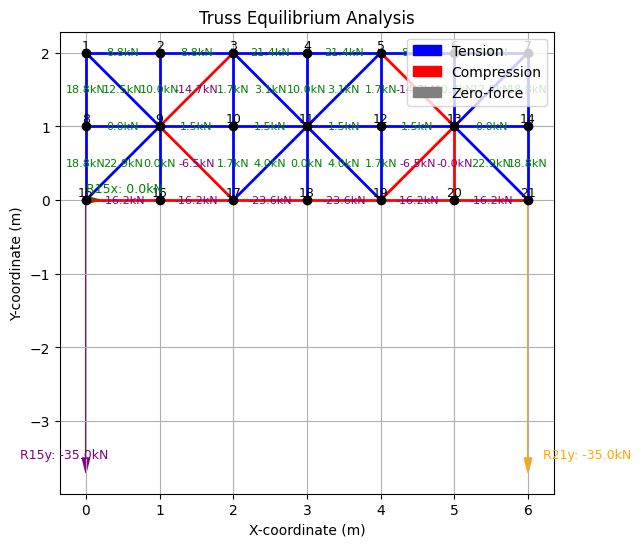

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Initial Fixed Member Forces:
  Member 33: 12.474431 kN
  Member 35: 22.880908 kN
  Member 37: 3.068577 kN
  Member 39: 4.002491 kN
  Member 41: -14.742509 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 488.285168 cubic units
Current Fixed Member Forces:
  Member 33: 12.473732 kN
  Member 35: 22.880124 kN
  Member 37: 3.067611 kN
  Member 39: 4.003201 kN
  Member 41: -14.743173 kN
--------------------------------------------------
Generation 3: New Best Volume = 488.284102 cubic units
Current Fixed Member Forces:
  Member 33: 12.473431 kN
  Member 35: 22.879975 kN
  Member 37: 3.068867 kN
  Member 39: 4.003089 kN
  Member 41: -14.742972 kN
--------------------------------------------------
Generation 4: New Best Volume = 488.282049 cubic units
Current Fixed Member Forces:
  Member 33: 12.473431 kN
  Member 35: 22.879908 kN
  Member 37: 3.068165 kN
  Member 39: 4.003029 kN
  Member 41: -14.743173 kN
-

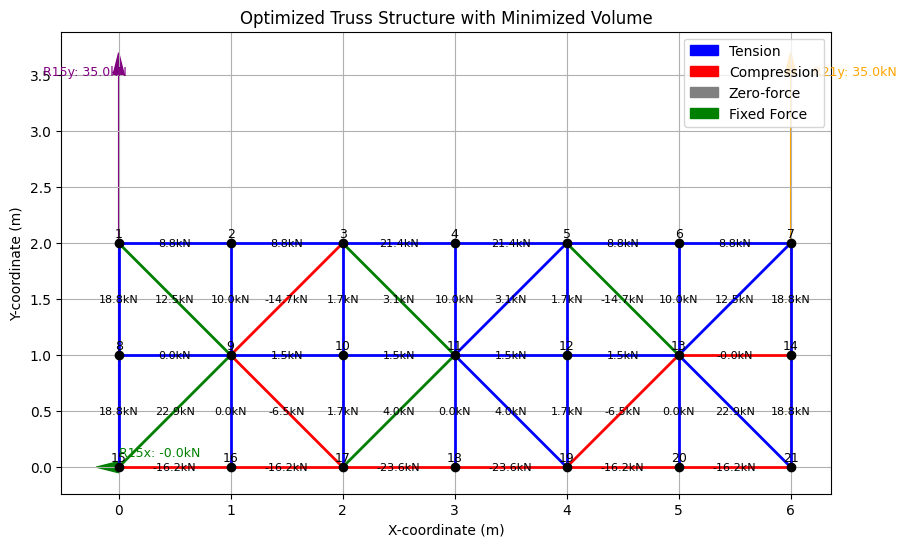

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import copy

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = [33, 35, 37, 39, 41]  # Members to be optimized
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN", color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=0.001):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds (±0.001 from seed)
        self.gene_bounds = [
            (force - 0.001, force + 0.001) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-self.MUTATION_AMOUNT, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=truss.fixed_member_ids,
        seed_fixed_forces=optimized_fixed_member_forces
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(truss.fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color and linewidth
        if m_id in truss.fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN",
                 color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define fixed members and their initial forces (seed)
    fixed_member_ids = truss.fixed_member_ids
    initial_forces = [member_forces[m_id - 1] for m_id in fixed_member_ids]
    seed_fixed_forces = {m_id: force for m_id, force in zip(fixed_member_ids, initial_forces)}

    print("--- Genetic Algorithm Optimization ---\n")
    print("Initial Fixed Member Forces:")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=0.001       # Maximum mutation change
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")


## Triple cell - dynamic fixing of members


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12            13            1.509434      Tension        
Member 12

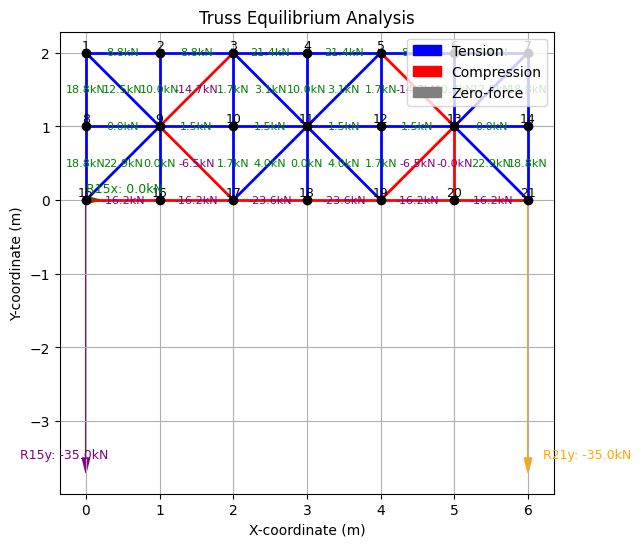

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 21: 10.000000 kN
  Member 18: -16.179245 kN
  Member 10: 1.509434 kN
  Member 3: 21.415094 kN
  Member 22: 0.000000 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 488.289288 cubic units
Current Fixed Member Forces:
  Member 21: 9.999284 kN
  Member 18: -16.179810 kN
  Member 10: 1.508685 kN
  Member 3: 21.414673 kN
  Member 22: 0.000370 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.287292 cubic units
Current Fixed Member Forces:
  Member 21: 9.999477 kN
  Member 18: -16.179810 kN
  Member 10: 1.508685 kN
  Member 3: 21.414094 kN
  Member 22: 0.000883 kN
--------------------------------------------------
Generation 3: New Best Volume = 488.283827 cubic units
Current Fixed Member Forces:
  Member 21: 9.999019 kN
  Member 18: -16.180245 kN
  Member 10: 1.509011 kN
  Member 3: 21.414345 kN
  Member 22: 0.000929 kN
---

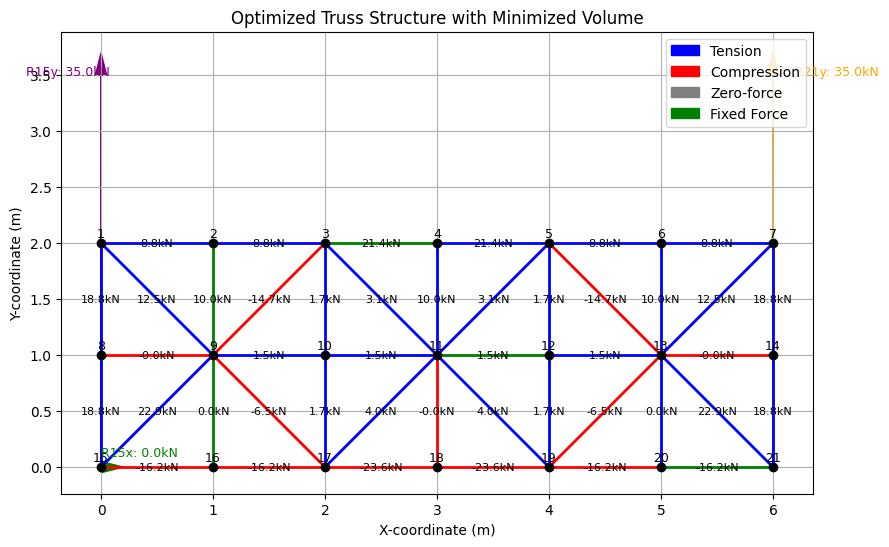

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import copy

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=0.001):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds (±0.001 from seed)
        self.gene_bounds = [
            (force - 0.001, force + 0.001) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-self.MUTATION_AMOUNT, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color and linewidth
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN",
                 color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define a function to select N random fixed members based on degree of indeterminacy
    def select_fixed_members(truss, degree_of_indeterminacy):
        return select_random_fixed_members(truss, degree_of_indeterminacy)

    # Select fixed members at random
    N = truss.degree_of_indeterminacy
    fixed_member_ids = select_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=0.001       # Maximum mutation change
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")


## Triple cell - optimised structure shown

* Optimised structure based on cross-sectional areas shown
* `USE_SEED` function can be changed to True/False based on whether a seed is wanted to be set

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12      

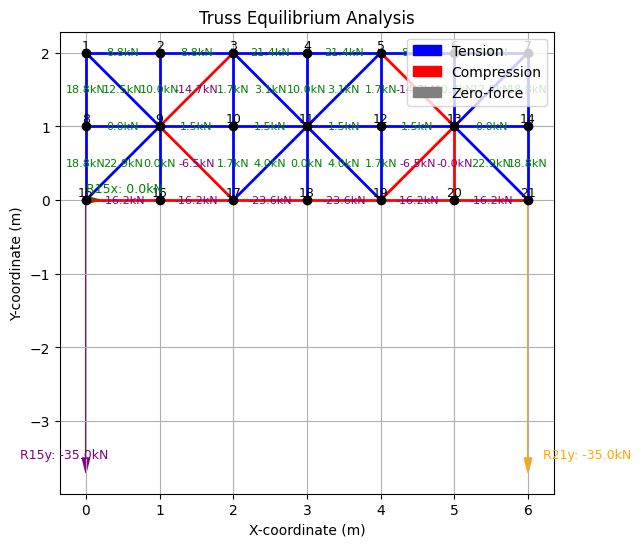

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 37: 3.068577 kN
  Member 35: 22.880908 kN
  Member 29: 10.000000 kN
  Member 4: 21.415094 kN
  Member 5: 8.820755 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 488.286807 cubic units
Current Fixed Member Forces:
  Member 37: 3.067731 kN
  Member 35: 22.880238 kN
  Member 29: 9.999414 kN
  Member 4: 21.416049 kN
  Member 5: 8.819801 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.286516 cubic units
Current Fixed Member Forces:
  Member 37: 3.067973 kN
  Member 35: 22.881011 kN
  Member 29: 9.999283 kN
  Member 4: 21.416058 kN
  Member 5: 8.821006 kN
--------------------------------------------------
Generation 3: New Best Volume = 488.283975 cubic units
Current Fixed Member Forces:
  Member 37: 3.067973 kN
  Member 35: 22.881806 kN
  Member 29: 9.999283 kN
  Member 4: 21.416044 kN
  Member 5: 8.820714 kN
-----------

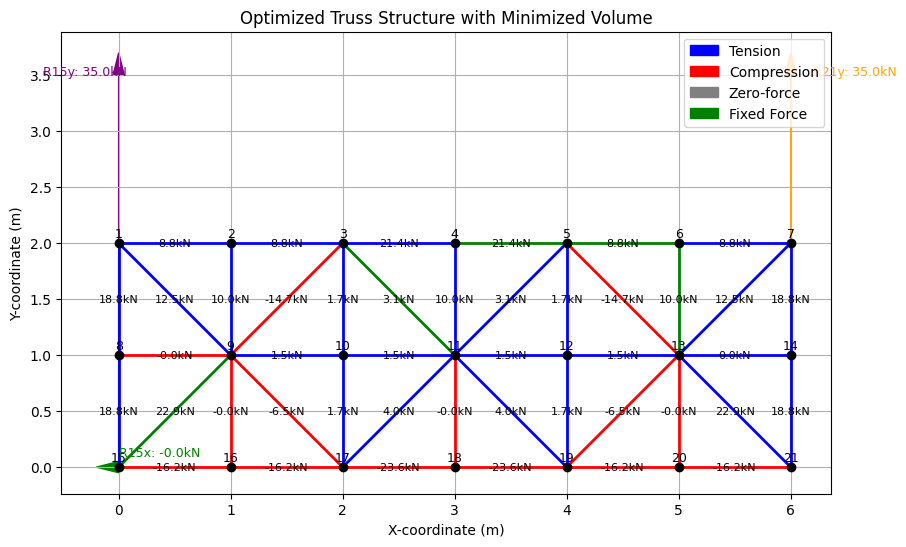

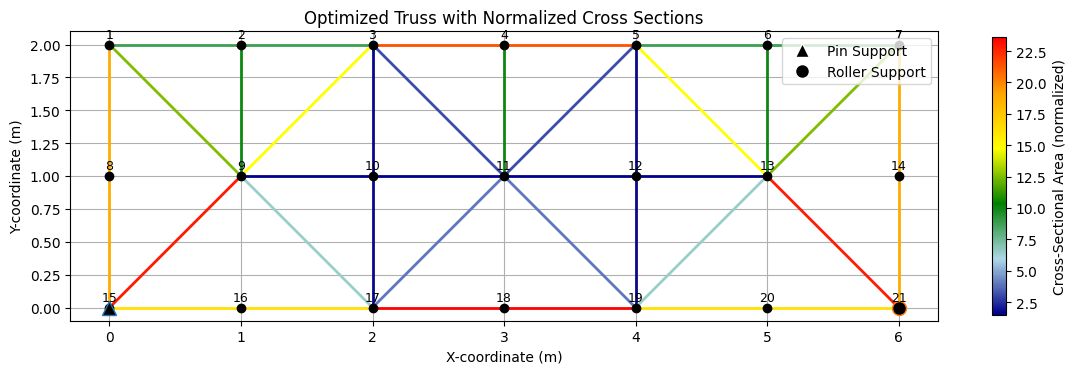

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=0.001):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds (±0.001 from seed)
        self.gene_bounds = [
            (force - 0.001, force + 0.001) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-self.MUTATION_AMOUNT, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='o', markersize=10, markerfacecolor='black', label='Roller Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                      markerfacecolor='black', markersize=10)
    roller_patch = Line2D([0], [0], marker='o', color='w', label='Roller Support',
                      markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch, roller_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define a function to select N random fixed members based on degree of indeterminacy
    def select_fixed_members(truss, degree_of_indeterminacy):
        return select_random_fixed_members(truss, degree_of_indeterminacy)

    # Select fixed members at random
    N = truss.degree_of_indeterminacy
    fixed_member_ids = select_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=0.001       # Maximum mutation change
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Re-test with greater GA tolerance

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12      

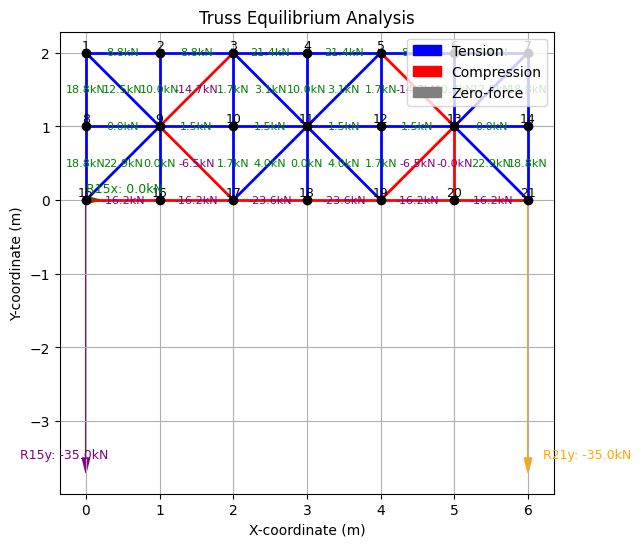

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 1: 8.820755 kN
  Member 44: 22.880908 kN
  Member 29: 10.000000 kN
  Member 3: 21.415094 kN
  Member 19: 18.820755 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 488.293130 cubic units
Current Fixed Member Forces:
  Member 1: 8.820848 kN
  Member 44: 22.880737 kN
  Member 29: 9.999026 kN
  Member 3: 21.415764 kN
  Member 19: 18.821149 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.290103 cubic units
Current Fixed Member Forces:
  Member 1: 8.819949 kN
  Member 44: 22.881106 kN
  Member 29: 9.999046 kN
  Member 3: 21.414954 kN
  Member 19: 18.821692 kN
--------------------------------------------------
Generation 3: New Best Volume = 488.288466 cubic units
Current Fixed Member Forces:
  Member 1: 8.819755 kN
  Member 44: 22.881796 kN
  Member 29: 9.999000 kN
  Member 3: 21.414954 kN
  Member 19: 18.821692 kN
-------

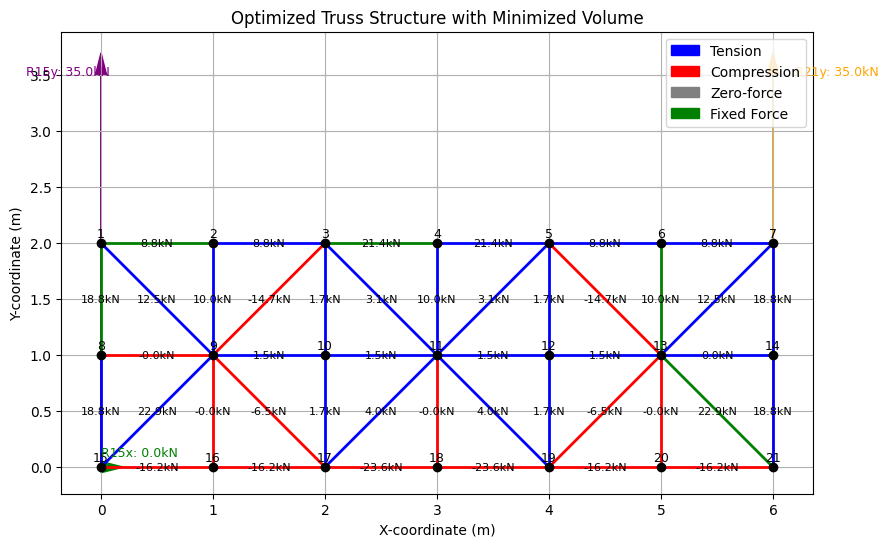

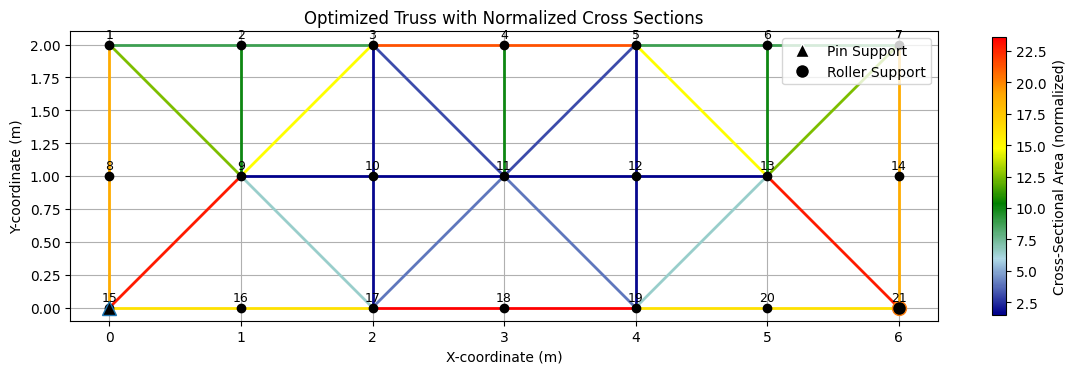

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=0.1):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds (±0.001 from seed)
        self.gene_bounds = [
            (force - 0.001, force + 0.001) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-self.MUTATION_AMOUNT, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='o', markersize=10, markerfacecolor='black', label='Roller Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                      markerfacecolor='black', markersize=10)
    roller_patch = Line2D([0], [0], marker='o', color='w', label='Roller Support',
                      markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch, roller_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define a function to select N random fixed members based on degree of indeterminacy
    def select_fixed_members(truss, degree_of_indeterminacy):
        return select_random_fixed_members(truss, degree_of_indeterminacy)

    # Select fixed members at random
    N = truss.degree_of_indeterminacy
    fixed_member_ids = select_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=0.001       # Maximum mutation change
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Issue arisen - optimum structure here is not the optimum structure

Fixed Member Forces (in kN):
Member 14 (Node 16 to Node 17): 0.00 kN
Member 36 (Node 9 to Node 17): 0.00 kN
Member 15 (Node 17 to Node 18): 0.00 kN
Member 17 (Node 19 to Node 20): 0.00 kN
Member 43 (Node 13 to Node 19): 0.00 kN

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             25.00         Tension        
Member 2     2             3             25.00         Tension        
Member 3     3             4             45.00         Tension        
Member 4     4             5             45.00         Tension        
Member 5     5             6             25.00         Tension        
Member 6     6             7             25.00         Tension        
Member 7     8             9             0.00          Zero-force     
Member 8     9             10            -40.00        Compression    
Member 9     10            11         

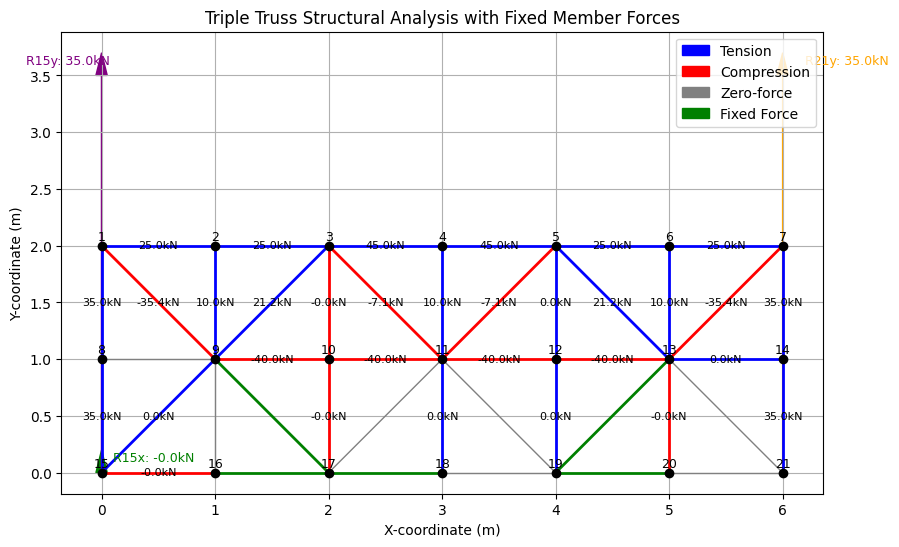


Total Volume of the Structure: 700.00 cubic units

Volume of Each Member:
Member    Start Node     End Node       Volume         
-------------------------------------------------------
Member 1     1             2             25.00        
Member 2     2             3             25.00        
Member 3     3             4             45.00        
Member 4     4             5             45.00        
Member 5     5             6             25.00        
Member 6     6             7             25.00        
Member 7     8             9             0.00         
Member 8     9             10            40.00        
Member 9     10            11            40.00        
Member 10    11            12            40.00        
Member 11    12            13            40.00        
Member 12    13            14            0.00         
Member 13    15            16            0.00         
Member 14    16            17            0.00         
Member 15    17            18            0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ------------- 1. Define the Nodes -------------

# Initialize nodes dictionary
nodes = {}
node_id = 1

# Create 7 columns (x=0 to 6) and 3 rows (y=2 to 0)
for y in range(2, -1, -1):  # y=2 (top) to y=0 (bottom)
    for x in range(7):       # x=0 to x=6
        nodes[node_id] = (x, y)
        node_id += 1

# ------------- 2. Define the Members -------------

# Reset members dictionary
members = {}
member_id = 1

# Function to add a member between two nodes with validation
def add_member(start, end):
    global member_id
    # Check if both start and end nodes exist
    if start in nodes and end in nodes:
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any((start == existing_start and end == existing_end) or
                   (start == existing_end and end == existing_start)
                   for existing_start, existing_end in members.values()):
            members[member_id] = (start, end)
            member_id += 1
    else:
        print(f"Skipping member ({start}, {end}) - Invalid node number.")

# ------------- Add Horizontal Members -------------
# Top Row: Nodes 1-7
for i in range(1, 7):
    add_member(i, i+1)

# Middle Row: Nodes 8-14
for i in range(8, 14):
    add_member(i, i+1)

# Bottom Row: Nodes 15-21
for i in range(15, 21):
    add_member(i, i+1)

# ------------- Add Vertical Members -------------
# Columns 1 to 7: Connect top to middle to bottom
for col in range(1, 8):
    top_node = col
    middle_node = col + 7
    bottom_node = col + 14
    add_member(top_node, middle_node)
    add_member(middle_node, bottom_node)

# ------------- Add Diagonal Members at Middle Nodes 9, 11, 13 -------------

# Define middle nodes where diagonals will be added
middle_nodes = [9, 11, 13]

# Directions: up-left, up-right, down-left, down-right
directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

for node in middle_nodes:
    x, y = nodes[node]
    for dx, dy in directions:
        diag_x = x + dx
        diag_y = y + dy
        # Find the node that matches (diag_x, diag_y)
        diag_node = None
        for nid, coord in nodes.items():
            if coord == (diag_x, diag_y):
                diag_node = nid
                break
        if diag_node:
            add_member(node, diag_node)

# ------------- 3. Define Support Reactions -------------

# Supports are at Node 15 (pin: R15x, R15y) and Node 21 (roller: R21y)
support_reactions = {
    'R15x': None,   # Reaction at Node 15 in x-direction
    'R15y': None,   # Reaction at Node 15 in y-direction
    'R21y': None    # Reaction at Node 21 in y-direction
}

num_reactions = len(support_reactions)  # 3 reactions

# ------------- 4. Initialize the System of Equilibrium Equations -------------

num_members = len(members)       # Number of members (44)
num_nodes = len(nodes)           # 21 nodes
equations_per_node = 2           # Sum Fx and Fy for each node
total_equations = num_nodes * equations_per_node  # 42 equations

total_unknowns = num_members + num_reactions  # 44 + 3 = 47 unknowns

# ------------- 5. Define External Loads -------------

# Evenly distributed downward loads on top nodes (Nodes 1 to 7)
external_loads = {}
load_magnitude = 10  # kN per node

for node in range(1, 8):  # Nodes 1 to 7
    external_loads[node] = (0, -load_magnitude)  # (Fx, Fy)

# ------------- 6. Define Direction Cosines -------------

def direction_cosines(start, end):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    delta_x = x2 - x1
    delta_y = y2 - y1
    length = np.sqrt(delta_x**2 + delta_y**2)
    if length == 0:
        raise ValueError(f"Zero length member between nodes {start} and {end}.")
    cos_theta = delta_x / length
    sin_theta = delta_y / length
    return cos_theta, sin_theta

# ------------- 7. Define Fixed Member Forces -------------

# Fixed member forces (Member ID: Force Value)
fixed_member_forces = {
    14: 0,
    36: 0,
    15: 0,
    17: 0,
    43: 0
}

# Zero-based indices of fixed member forces
fixed_member_indices = [m - 1 for m in fixed_member_forces.keys()]

# ------------- 8. Create Mapping for Unknown Indices -------------

# List of member indices (0-based) that are unknowns
unknown_member_indices = [i for i in range(num_members) if i not in fixed_member_indices]

# Total unknowns after removing fixed member forces
num_unknowns = len(unknown_member_indices) + num_reactions  # 39 + 3 = 42 unknowns

# Create a mapping from member index to unknown index
member_index_to_unknown = {}
unknown_index = 0
for i in range(num_members):
    if i not in fixed_member_indices:
        member_index_to_unknown[i] = unknown_index
        unknown_index += 1
# Map reactions to unknown indices
reaction_indices = range(num_unknowns - num_reactions, num_unknowns)

# ------------- 9. Initialize the Coefficient Matrix A and Load Vector B -------------

A = np.zeros((total_equations, num_unknowns))  # 42x42
B = np.zeros(total_equations)                  # 42-element vector

# ------------- 10. Populate the Coefficient Matrix A and Load Vector B -------------

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B[eq_x] += load[0]  # External load in x-direction
    B[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        member_index = m - 1  # Zero-based index
        if node == start or node == end:
            # Always calculate direction cosines from start to end
            try:
                cos_theta, sin_theta = direction_cosines(start, end)
            except ValueError as ve:
                print(ve)
                continue

            # Determine the sign of the coefficients based on node position
            if node == start:
                coef_x = cos_theta
                coef_y = sin_theta
            else:  # node == end
                coef_x = -cos_theta
                coef_y = -sin_theta

            if member_index in fixed_member_indices:
                # Subtract the fixed member force contribution from B
                fixed_force = fixed_member_forces[m]
                B[eq_x] -= coef_x * fixed_force
                B[eq_y] -= coef_y * fixed_force
            else:
                # Add coefficients to A matrix
                unknown_idx = member_index_to_unknown[member_index]
                A[eq_x, unknown_idx] += coef_x
                A[eq_y, unknown_idx] += coef_y

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A[eq_x, num_unknowns - num_reactions + 0] -= 1   # R15x
        A[eq_y, num_unknowns - num_reactions + 1] -= 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A[eq_y, num_unknowns - num_reactions + 2] -= 1   # R21y

# ------------- 11. Solve the System -------------

# Solve the system A * F_unknowns = B
try:
    F_unknowns = np.linalg.solve(A, B)
    equilibrium_satisfied = True
except np.linalg.LinAlgError:
    # If A is singular or not invertible, use least squares
    F_unknowns, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
    equilibrium_satisfied = False

# ------------- 12. Reconstruct the Full Solution Vector F -------------

F_full = np.zeros(total_unknowns)  # 47-element vector (44 members + 3 reactions)

# Insert the solved unknown member forces into F_full
for member_index in unknown_member_indices:
    unknown_idx = member_index_to_unknown[member_index]
    F_full[member_index] = F_unknowns[unknown_idx]

# Insert the fixed member forces into F_full
for m, force in fixed_member_forces.items():
    member_index = m - 1  # Zero-based index
    F_full[member_index] = force

# Insert reaction forces into F_full
for i in range(num_reactions):
    F_full[num_members + i] = F_unknowns[num_unknowns - num_reactions + i]

# Extract member forces and reaction forces
member_forces = F_full[:num_members]
reaction_forces = F_full[num_members:]

# ------------- 13. Display the Results -------------

# Display fixed member forces
print("Fixed Member Forces (in kN):")
for m, force in fixed_member_forces.items():
    start, end = members[m]
    print(f"Member {m} (Node {start} to Node {end}): {force:.2f} kN")

print("\nMember Forces (in kN):")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
print("-" * 70)
for m in members:
    start, end = members[m]
    force = member_forces[m - 1]
    if m in fixed_member_forces:
        status = "Fixed"
    else:
        if force > 0:
            status = "Tension"
        elif force < 0:
            status = "Compression"
        else:
            status = "Zero-force"
    print(f"Member {m:<5} {start:<13} {end:<13} {force:<13.2f} {status:<15}")

# Display support reactions
print("\nSupport Reactions (in kN):")
for i, reaction in enumerate(support_reactions):
    force = reaction_forces[i]
    print(f"{reaction}: {force:.2f} kN")

# ------------- 14. Check Equilibrium -------------

# Reconstruct B using the full F vector
A_full = np.zeros((total_equations, total_unknowns))
B_full = np.zeros(total_equations)

for node in nodes:
    # Equation indices
    eq_x = (node - 1) * 2      # Sum Fx
    eq_y = eq_x + 1            # Sum Fy

    # Assign external loads to B
    load = external_loads.get(node, (0, 0))
    B_full[eq_x] += load[0]  # External load in x-direction
    B_full[eq_y] += load[1]  # External load in y-direction

    # Iterate through all members to see if they are connected to the current node
    for m in members:
        start, end = members[m]
        member_index = m - 1  # Zero-based index
        if node == start or node == end:
            # Always calculate direction cosines from start to end
            try:
                cos_theta, sin_theta = direction_cosines(start, end)
            except ValueError as ve:
                print(ve)
                continue

            # Determine the sign of the coefficients based on node position
            if node == start:
                coef_x = cos_theta
                coef_y = sin_theta
            else:  # node == end
                coef_x = -cos_theta
                coef_y = -sin_theta

            A_full[eq_x, member_index] += coef_x
            A_full[eq_y, member_index] += coef_y

    # Assign support reactions to the equations if the node has a support
    if node == 15:
        # Reactions R15x and R15y affect Sum Fx and Sum Fy at Node 15
        A_full[eq_x, num_members + 0] -= 1   # R15x
        A_full[eq_y, num_members + 1] -= 1   # R15y
    if node == 21:
        # Reaction R21y affects Sum Fy at Node 21
        A_full[eq_y, num_members + 2] -= 1   # R21y

# Check equilibrium
B_calculated = np.dot(A_full, F_full)
difference = B_calculated - B_full
tolerance = 1e-6
if np.all(np.abs(difference) < tolerance):
    print("\nEquilibrium is satisfied.")
else:
    print("\nEquilibrium is NOT satisfied. Check the calculations.")
    # For debugging, print the maximum difference
    max_diff = np.max(np.abs(difference))
    print(f"Maximum difference: {max_diff}")

# ------------- 15. Graphical Visualization -------------

def plot_truss(nodes, members, member_forces, reaction_forces, title="Truss Analysis"):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for tension and compression
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m in members:
        start, end = members[m]
        x_start, y_start = nodes[start]
        x_end, y_end = nodes[end]
        force = member_forces[m - 1]

        # Determine color based on force
        if m in fixed_member_forces:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN", color='black',
                     fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node in nodes:
        x, y = nodes[node]
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = nodes[15]
    # Reaction R15x (Horizontal)
    plt.arrow(x15, y15, reaction_forces[0]/10, 0, head_width=0.1, head_length=0.2, fc='green', ec='green')
    plt.text(x15 + reaction_forces[0]/10 + 0.1, y15 + 0.1, f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    plt.arrow(x15, y15, 0, reaction_forces[1]/10, head_width=0.1, head_length=0.2, fc='purple', ec='purple')
    plt.text(x15 - 0.3, y15 + reaction_forces[1]/10 + 0.1, f"R15y: {reaction_forces[1]:.1f}kN", color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = nodes[21]
    # Reaction R21y (Vertical)
    plt.arrow(x21, y21, 0, reaction_forces[2]/10, head_width=0.1, head_length=0.2, fc='orange', ec='orange')
    plt.text(x21 + 0.2, y21 + reaction_forces[2]/10 + 0.1, f"R21y: {reaction_forces[2]:.1f}kN", color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# Call the plotting function with the updated structure
plot_truss(nodes, members, member_forces, reaction_forces, title="Triple Truss Structural Analysis with Fixed Member Forces")

# ------------- 16. Calculate Total Volume of the Structure -------------

material_stress = 1  # Given material stress
total_volume = 0.0   # Initialize total volume

# Dictionary to store volume of each member
member_volumes = {}

for m in members:
    start_node, end_node = members[m]
    x1, y1 = nodes[start_node]
    x2, y2 = nodes[end_node]
    # Calculate length of the member
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    # Get the force in the member
    force = member_forces[m - 1]
    # Obtain magnitude of the force
    force_magnitude = abs(force)
    # Calculate cross-sectional area (A = |F| / σ)
    cross_sectional_area = force_magnitude / material_stress
    # Calculate volume (V = A * L)
    volume = cross_sectional_area * length
    # Add to total volume
    total_volume += volume
    # Store volume of the member
    member_volumes[m] = volume

# Display the total volume
print(f"\nTotal Volume of the Structure: {total_volume:.2f} cubic units")

# Optionally, display volume per member
print("\nVolume of Each Member:")
print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Volume':<15}")
print("-" * 55)
for m in member_volumes:
    start, end = members[m]
    volume = member_volumes[m]
    print(f"Member {m:<5} {start:<13} {end:<13} {volume:<13.2f}")



# Re-working optimisation code

## Ensuring specific members are specifically selected for usage

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12      

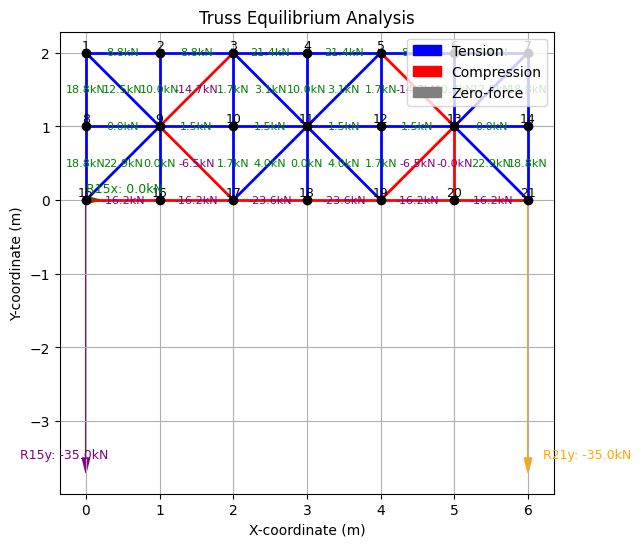

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 11: 1.509434 kN
  Member 34: -14.742509 kN
  Member 35: 22.880908 kN
  Member 41: -14.742509 kN
  Member 44: 22.880908 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 488.288365 cubic units
Current Fixed Member Forces:
  Member 11: 1.510332 kN
  Member 34: -14.742625 kN
  Member 35: 22.881175 kN
  Member 41: -14.743174 kN
  Member 44: 22.880121 kN
--------------------------------------------------
Generation 2: New Best Volume = 488.279510 cubic units
Current Fixed Member Forces:
  Member 11: 1.510234 kN
  Member 34: -14.743509 kN
  Member 35: 22.880467 kN
  Member 41: -14.743499 kN
  Member 44: 22.879908 kN
--------------------------------------------------
Generation 5: New Best Volume = 488.278081 cubic units
Current Fixed Member Forces:
  Member 11: 1.510434 kN
  Member 34: -14.743509 kN
  Member 35: 22.879908 kN
  Member 41: -14.743478 kN
  Member 44: 2

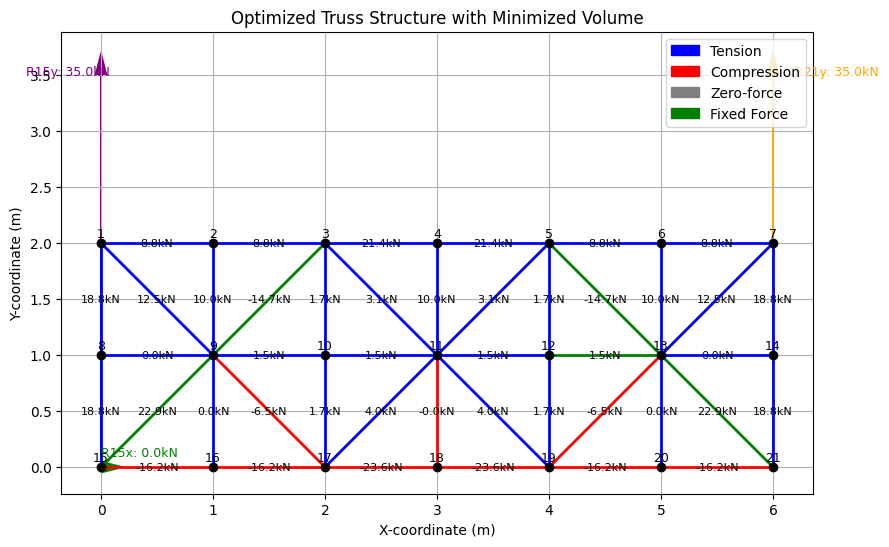

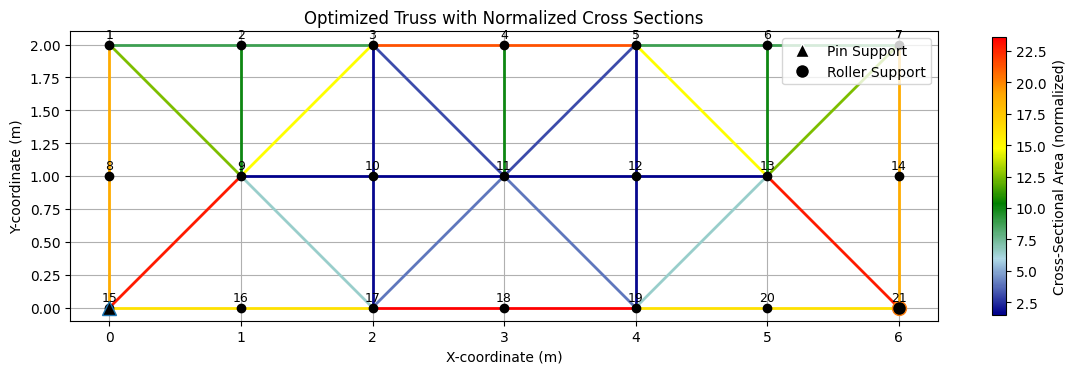

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [11, 34, 35, 41, 44]  # Example list of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=0.1):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds (±0.001 from seed)
        self.gene_bounds = [
            (force - 0.001, force + 0.001) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-self.MUTATION_AMOUNT, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='o', markersize=10, markerfacecolor='black', label='Roller Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                      markerfacecolor='black', markersize=10)
    roller_patch = Line2D([0], [0], marker='o', color='w', label='Roller Support',
                      markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch, roller_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define a function to select N random fixed members based on degree of indeterminacy
    def select_fixed_members(truss, N):
        return select_random_fixed_members(truss, N)

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=10       # Maximum mutation change
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Changing the optimisation to increase fixed member forces

Random seeds are not set. Results may vary with each run.


--- Truss Equilibrium Analysis Results ---

Member Forces (in kN):
Member    Start Node     End Node       Force (kN)     Status         
----------------------------------------------------------------------
Member 1     1             2             8.820755      Tension        
Member 2     2             3             8.820755      Tension        
Member 3     3             4             21.415094     Tension        
Member 4     4             5             21.415094     Tension        
Member 5     5             6             8.820755      Tension        
Member 6     6             7             8.820755      Tension        
Member 7     8             9             0.000000      Tension        
Member 8     9             10            1.509434      Tension        
Member 9     10            11            1.509434      Tension        
Member 10    11            12            1.509434      Tension        
Member 11    12      

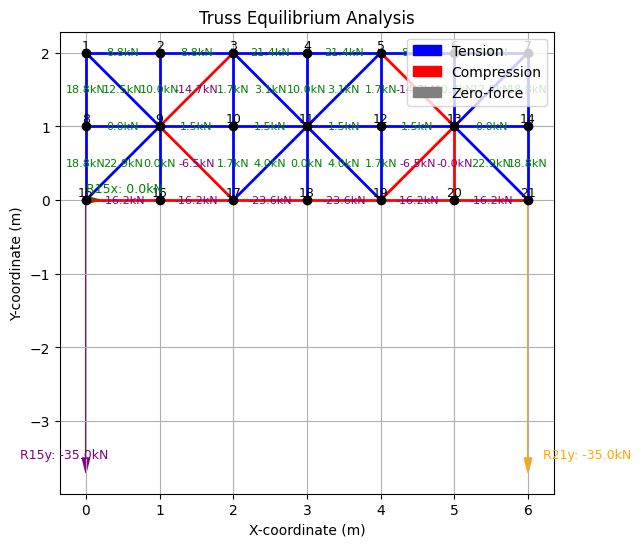

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 11: 1.509434 kN
  Member 34: -14.742509 kN
  Member 35: 22.880908 kN
  Member 41: -14.742509 kN
  Member 44: 22.880908 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 1280.830948 cubic units
Current Fixed Member Forces:
  Member 11: 79.512278 kN
  Member 34: 26.457131 kN
  Member 35: 40.652634 kN
  Member 41: -3.733688 kN
  Member 44: 76.099560 kN
--------------------------------------------------
Generation 2: New Best Volume = 1098.906605 cubic units
Current Fixed Member Forces:
  Member 11: 68.883472 kN
  Member 34: 29.591346 kN
  Member 35: 39.059303 kN
  Member 41: 1.463632 kN
  Member 44: 46.416342 kN
--------------------------------------------------
Generation 3: New Best Volume = 1011.470567 cubic units
Current Fixed Member Forces:
  Member 11: 78.661516 kN
  Member 34: 11.496659 kN
  Member 35: 37.075297 kN
  Member 41: 22.991292 kN
  Member 44: 40

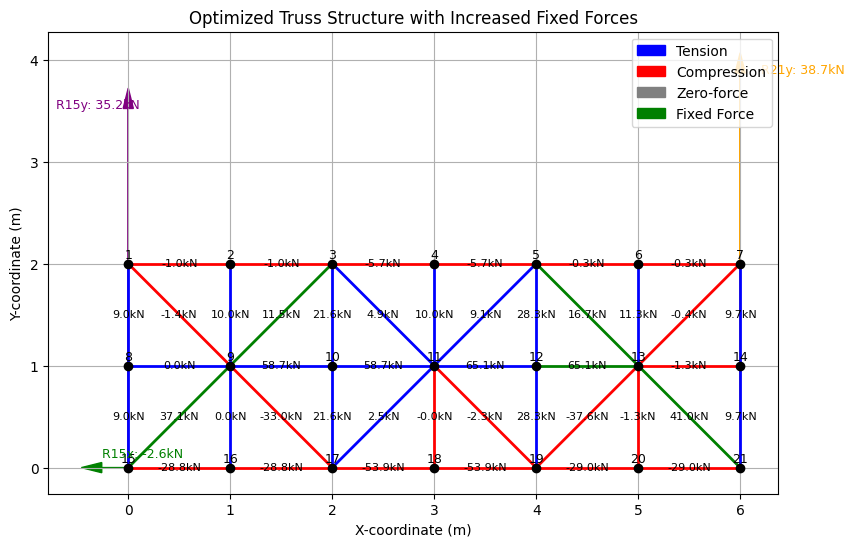

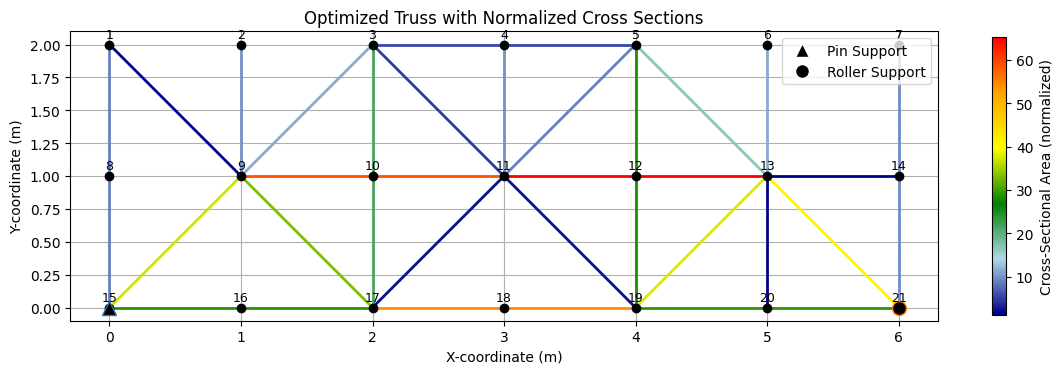

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [11, 34, 35, 41, 44]  # Example list of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=10):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds: Lower bound is seed force + 10kN, Upper bound is seed force + 100kN
        self.gene_bounds = [
            (force + 10.0, force + 100.0) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                # Mutation only allows increase
                mutation = random.uniform(0, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = min(individual[i], high)
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='o', markersize=10, markerfacecolor='black', label='Roller Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                      markerfacecolor='black', markersize=10)
    roller_patch = Line2D([0], [0], marker='o', color='w', label='Roller Support',
                      markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch, roller_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Define a function to select N random fixed members based on degree of indeterminacy
    def select_fixed_members(truss, N):
        return select_random_fixed_members(truss, N)

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=10          # Maximum mutation change (kN)
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Increased Fixed Forces")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


Random seeds are not set. Results may vary with each run.

--- Truss Members ---
Member 1: Node 1 to Node 2
Member 2: Node 2 to Node 3
Member 3: Node 3 to Node 4
Member 4: Node 4 to Node 5
Member 5: Node 5 to Node 6
Member 6: Node 6 to Node 7
Member 7: Node 8 to Node 9
Member 8: Node 9 to Node 10
Member 9: Node 10 to Node 11
Member 10: Node 11 to Node 12
Member 11: Node 12 to Node 13
Member 12: Node 13 to Node 14
Member 13: Node 15 to Node 16
Member 14: Node 16 to Node 17
Member 15: Node 17 to Node 18
Member 16: Node 18 to Node 19
Member 17: Node 19 to Node 20
Member 18: Node 20 to Node 21
Member 19: Node 1 to Node 8
Member 20: Node 8 to Node 15
Member 21: Node 2 to Node 9
Member 22: Node 9 to Node 16
Member 23: Node 3 to Node 10
Member 24: Node 10 to Node 17
Member 25: Node 4 to Node 11
Member 26: Node 11 to Node 18
Member 27: Node 5 to Node 12
Member 28: Node 12 to Node 19
Member 29: Node 6 to Node 13
Member 30: Node 13 to Node 20
Member 31: Node 7 to Node 14
Member 32: Node 14 to No

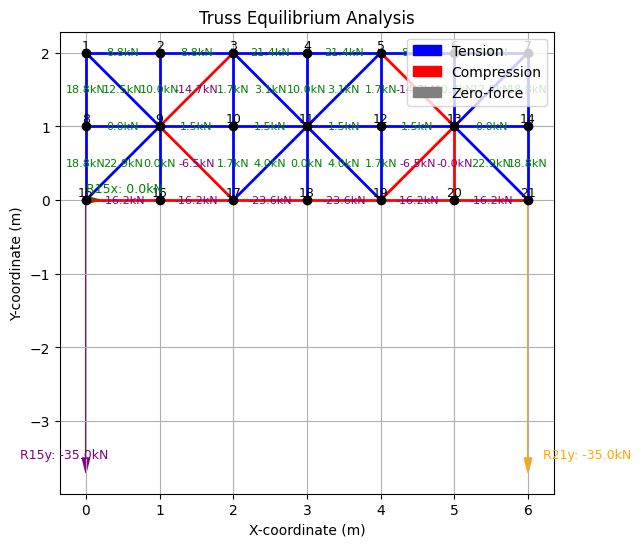

Total Structure Volume (Initial): 488.301887 cubic units

Degree of Indeterminacy: 5

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 5):
  Member 11: 1.509434 kN
  Member 34: -14.742509 kN
  Member 35: 22.880908 kN
  Member 41: -14.742509 kN
  Member 44: 22.880908 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 1260.497642 cubic units
Current Fixed Member Forces:
  Member 11: 33.597850 kN
  Member 34: 10.275661 kN
  Member 35: 58.829335 kN
  Member 41: 1.498826 kN
  Member 44: 64.898299 kN
--------------------------------------------------
Generation 3: New Best Volume = 1223.652579 cubic units
Current Fixed Member Forces:
  Member 11: 68.693702 kN
  Member 34: 26.916080 kN
  Member 35: 44.110077 kN
  Member 41: 1.498826 kN
  Member 44: 66.338885 kN
--------------------------------------------------
Generation 4: New Best Volume = 1206.329424 cubic units
Current Fixed Member Forces:
  Member 11: 41.176033 kN
  Member 34: 5.615191 kN
  Member 35

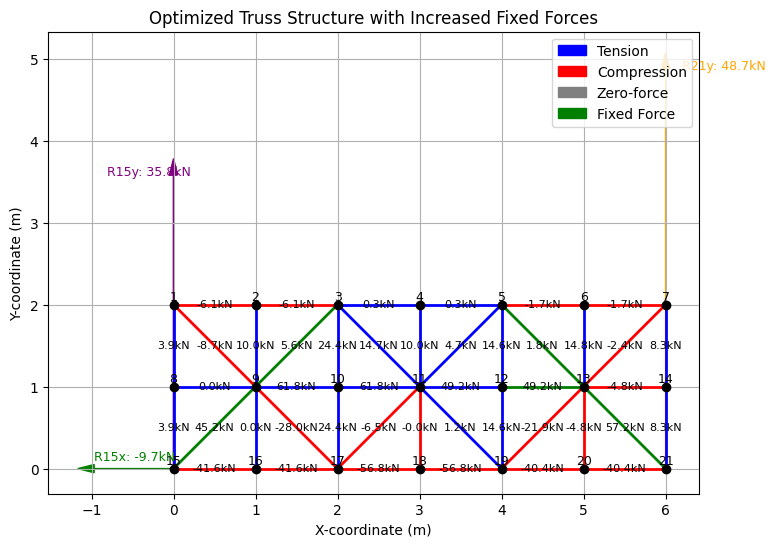

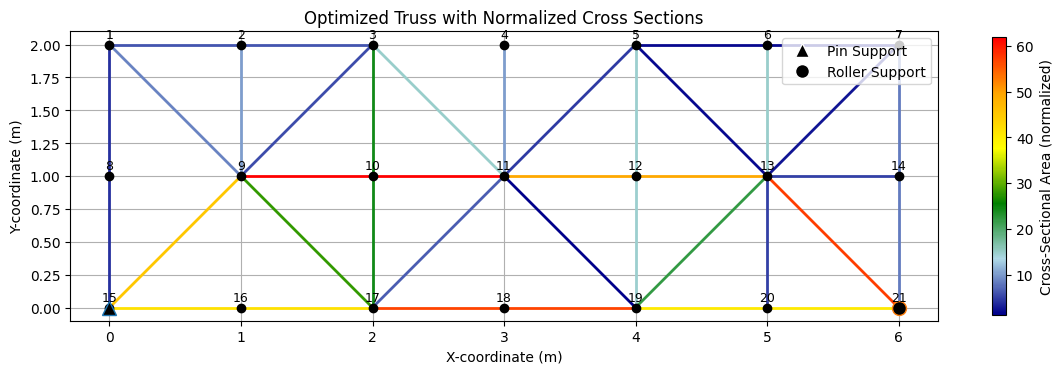

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [11, 34, 35, 41, 44]  # Example list of member IDs to fix

# ------------------------- Part 1: Truss Equilibrium Analysis -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10, material_stress=1.0):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.material_stress = material_stress  # Added material_stress attribute
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

    def setup_equilibrium_matrix(self):
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)
        num_nodes = len(self.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = num_members + num_reactions

        A = np.zeros((total_equations, total_unknowns))
        B = np.zeros(total_equations)

        for node in self.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.external_loads.get(node, (0, 0))
            B[eq_x] += load[0]
            B[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.members.items():
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.direction_cosines(node, other)
                    member_index = m_id - 1
                    if node == start:
                        A[eq_x, member_index] += cos_theta
                        A[eq_y, member_index] += sin_theta
                    else:
                        A[eq_x, member_index] += -cos_theta
                        A[eq_y, member_index] += -sin_theta

            # Assign support reactions
            if node == 15:
                A[eq_x, num_members + 0] += 1   # R15x
                A[eq_y, num_members + 1] += 1   # R15y
            if node == 21:
                A[eq_y, num_members + 2] += 1   # R21y

        return A, B

    def solve_equilibrium(self, A, B):
        try:
            F = np.linalg.solve(A, B)
            equilibrium_satisfied = True
        except np.linalg.LinAlgError:
            F, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)
            equilibrium_satisfied = False
        return F, equilibrium_satisfied

    def analyze_truss(self):
        A, B = self.setup_equilibrium_matrix()
        F, equilibrium_satisfied = self.solve_equilibrium(A, B)
        num_members = len(self.members)
        num_reactions = len(self.support_reactions)

        member_forces = F[:num_members]
        reaction_forces = F[num_members:]

        self.display_results(member_forces, reaction_forces, equilibrium_satisfied, A, F, B)
        self.plot_truss(member_forces, reaction_forces, title="Truss Equilibrium Analysis")

        # Compute and print total volume after initial analysis
        total_volume = self.compute_total_volume(member_forces)
        print(f"Total Structure Volume (Initial): {total_volume:.6f} cubic units\n")

        return member_forces, reaction_forces

    def display_results(self, member_forces, reaction_forces, equilibrium_satisfied, A, F, B):
        print("\n--- Truss Equilibrium Analysis Results ---\n")
        print("Member Forces (in kN):")
        print(f"{'Member':<10}{'Start Node':<15}{'End Node':<15}{'Force (kN)':<15}{'Status':<15}")
        print("-" * 70)
        for m_id, (start, end) in self.members.items():
            force = member_forces[m_id - 1]
            status = "Tension" if force > 0 else ("Compression" if force < 0 else "Zero-force")
            print(f"Member {m_id:<5} {start:<13} {end:<13} {force:<13.6f} {status:<15}")

        print("\nSupport Reactions (in kN):")
        for i, reaction in enumerate(self.support_reactions):
            force = reaction_forces[i]
            print(f"{reaction}: {force:.6f} kN")

        # Check equilibrium
        if equilibrium_satisfied:
            print("\nEquilibrium is satisfied.")
        else:
            B_calculated = np.dot(A, F)
            difference = B_calculated - B
            tolerance = 1e-7
            if np.all(np.abs(difference) < tolerance):
                print("\nEquilibrium is satisfied.")
            else:
                print("\nEquilibrium is NOT satisfied. Check the calculations.")

        print(f"\nDegree of Indeterminacy: {self.degree_of_indeterminacy}\n")

    def plot_truss(self, member_forces, reaction_forces, title="Truss Analysis"):
        plt.figure(figsize=(14, 6))
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.title(title)
        plt.xlabel('X-coordinate (m)')
        plt.ylabel('Y-coordinate (m)')

        # Define colors for tension and compression
        tension_color = 'blue'
        compression_color = 'red'
        zero_color = 'gray'

        # Plot each member
        for m_id, (start, end) in self.members.items():
            x_start, y_start = self.nodes[start]
            x_end, y_end = self.nodes[end]
            force = member_forces[m_id - 1]

            # Determine color based on force
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

            # Plot the member
            plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

            # Annotate the force value at the midpoint
            x_mid = (x_start + x_end) / 2
            y_mid = (y_start + y_end) / 2
            if force != 0:
                plt.text(x_mid, y_mid, f"{force:.1f}kN",
                         color='green' if force > 0 else 'purple',
                         fontsize=8, ha='center', va='center')

        # Plot the nodes
        for node, (x, y) in self.nodes.items():
            plt.plot(x, y, 'ko')  # Black circles for nodes
            plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

        # Annotate support reactions
        self.annotate_reactions(reaction_forces)

        # Create custom legend
        tension_patch = mpatches.Patch(color=tension_color, label='Tension')
        compression_patch = mpatches.Patch(color=compression_color, label='Compression')
        zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
        plt.legend(handles=[tension_patch, compression_patch, zero_patch], loc='upper right')

        plt.grid(True)
        plt.show()

    def compute_total_volume(self, member_forces):
        total_volume = 0.0
        for m_id, (start, end) in self.members.items():
            x1, y1 = self.nodes[start]
            x2, y2 = self.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(member_forces[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress  # Using the defined material_stress
            volume = cross_sectional_area * length
            total_volume += volume
        return total_volume

    def annotate_reactions(self, reaction_forces):
        num_members = len(self.members)
        # Node 15 (Pin Support)
        x15, y15 = self.nodes[15]
        # Reaction R15x (Horizontal)
        if reaction_forces[0] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[0] > 0 else -1
            plt.arrow(x15, y15, reaction_forces[0]/10, 0,
                      head_width=0.1, head_length=0.2, fc='green', ec='green')
            plt.text(x15 + reaction_forces[0]/10, y15 + 0.1,
                     f"R15x: {reaction_forces[0]:.1f}kN", color='green', fontsize=9, ha='left')
        # Reaction R15y (Vertical)
        if reaction_forces[1] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[1] > 0 else -1
            plt.arrow(x15, y15, 0, reaction_forces[1]/10,
                      head_width=0.1, head_length=0.2, fc='purple', ec='purple')
            plt.text(x15 - 0.3, y15 + reaction_forces[1]/10,
                     f"R15y: {reaction_forces[1]:.1f}kN",
                     color='purple', fontsize=9, ha='center')

        # Node 21 (Roller Support)
        x21, y21 = self.nodes[21]
        # Reaction R21y (Vertical)
        if reaction_forces[2] != 0:
            scale = 0.5  # Scale for visualization
            direction = 1 if reaction_forces[2] > 0 else -1
            plt.arrow(x21, y21, 0, reaction_forces[2]/10,
                      head_width=0.1, head_length=0.2, fc='orange', ec='orange')
            plt.text(x21 + 0.2, y21 + reaction_forces[2]/10,
                     f"R21y: {reaction_forces[2]:.1f}kN",
                     color='orange', fontsize=9, ha='left')

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, member_forces, reaction_forces, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1.0, population_size=50, generations=100,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.2, mutation_amount=10):
        self.truss = truss
        self.member_forces = member_forces
        self.reaction_forces = reaction_forces
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount

        # Define gene bounds: Lower bound is seed force + 10kN, Upper bound is seed force + 100kN
        self.gene_bounds = [
            (force + 10.0, force + 100.0) for force in self.seed_fixed_forces.values()
        ]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Reconstruct full member forces
        F_full_ga = np.zeros(self.num_members)
        for member_index in self.unknown_member_indices:
            unknown_idx = self.member_index_to_unknown[member_index]
            F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
        for i, m_id in enumerate(self.seed_fixed_member_ids):
            F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

        # Calculate total volume
        total_volume = 0.0
        for m_id, (start, end) in self.truss.members.items():
            x1, y1 = self.truss.nodes[start]
            x2, y2 = self.truss.nodes[end]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            force_magnitude = abs(F_full_ga[m_id - 1])
            cross_sectional_area = force_magnitude / self.material_stress
            volume = cross_sectional_area * length
            total_volume += volume

        return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, len(self.unknown_member_indices) + 0] -= 1   # R15x
                A_ga[eq_y, len(self.unknown_member_indices) + 1] -= 1   # R15y
            if node == 21:
                A_ga[eq_y, len(self.unknown_member_indices) + 2] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                # Mutation only allows increase
                mutation = random.uniform(0, self.MUTATION_AMOUNT)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = min(individual[i], high)
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {current_best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []
            for i in range(0, self.POPULATION_SIZE, 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < self.POPULATION_SIZE else selected[0]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=truss.material_stress  # Use truss's material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    # Reaction R15x (Horizontal)
    if reaction_forces_ga[0] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[0] > 0 else -1
        plt.arrow(x15, y15, reaction_forces_ga[0]/10, 0,
                  head_width=0.1, head_length=0.2, fc='green', ec='green')
        plt.text(x15 + reaction_forces_ga[0]/10, y15 + 0.1,
                 f"R15x: {reaction_forces_ga[0]:.1f}kN", color='green', fontsize=9, ha='left')
    # Reaction R15y (Vertical)
    if reaction_forces_ga[1] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[1] > 0 else -1
        plt.arrow(x15, y15, 0, reaction_forces_ga[1]/10,
                  head_width=0.1, head_length=0.2, fc='purple', ec='purple')
        plt.text(x15 - 0.3, y15 + reaction_forces_ga[1]/10,
                 f"R15y: {reaction_forces_ga[1]:.1f}kN",
                 color='purple', fontsize=9, ha='center')

    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    # Reaction R21y (Vertical)
    if reaction_forces_ga[2] != 0:
        scale = 0.5  # Scale for visualization
        direction = 1 if reaction_forces_ga[2] > 0 else -1
        plt.arrow(x21, y21, 0, reaction_forces_ga[2]/10,
                  head_width=0.1, head_length=0.2, fc='orange', ec='orange')
        plt.text(x21 + 0.2, y21 + reaction_forces_ga[2]/10,
                 f"R21y: {reaction_forces_ga[2]:.1f}kN",
                 color='orange', fontsize=9, ha='left')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1.0, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=[],  # Not used here
        reaction_forces=[],  # Not used here
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Roller Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='o', markersize=10, markerfacecolor='black', label='Roller Support')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                      markerfacecolor='black', markersize=10)
    roller_patch = Line2D([0], [0], marker='o', color='w', label='Roller Support',
                      markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch, roller_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # List all member IDs for verification
    print("--- Truss Members ---")
    for m_id, (start, end) in truss.members.items():
        print(f"Member {m_id}: Node {start} to Node {end}")
    print("\n")

    # Perform equilibrium analysis
    member_forces, reaction_forces = truss.analyze_truss()

    # Print degree of indeterminacy
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Validate specified fixed member IDs
    if SPECIFY_FIXED_MEMBERS:
        invalid_ids = [m for m in SPECIFIED_FIXED_MEMBER_IDS if m not in truss.members]
        if invalid_ids:
            print(f"Error: The following specified fixed member IDs do not exist: {invalid_ids}")
            print("Please provide valid member IDs.")
            exit(1)
        if len(SPECIFIED_FIXED_MEMBER_IDS) != truss.degree_of_indeterminacy:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({truss.degree_of_indeterminacy}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, truss.degree_of_indeterminacy)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Extract initial forces for the selected fixed members
    seed_fixed_forces = {m_id: member_forces[m_id - 1] for m_id in fixed_member_ids}

    # Print selected fixed members and their forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {len(fixed_member_ids)}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        member_forces=member_forces,
        reaction_forces=reaction_forces,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=truss.material_stress,  # Use truss's material_stress
        population_size=50,         # Number of individuals in the population
        generations=100,            # Number of generations to run
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.2,          # Probability of mutation per gene
        mutation_amount=10          # Maximum mutation change (kN)
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Increased Fixed Forces")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=truss.material_stress, title="Optimized Truss with Normalized Cross Sections")
